# 1. CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import (
    Dense, BatchNormalization, Conv1D, Dropout, Flatten,
    MaxPooling1D, SpatialDropout1D
    )

In [ ]:
# setup backend of  visualisation
plt.style.use("ggplot")

In [ ]:
# define f1-score metrics
def F1Score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# define list_metrics used for iterate learning
list_metrics = ["accuracy", Precision(), Recall(), F1Score]

# define global variable for training model
EPOCHS = 100
BATCH_SIZE = 64

In [ ]:
list_cols = [ "pktTotalCount", "octetTotalCount", "min_ps", "max_ps", "avg_ps",
    "std_dev_ps", "flowStart", "flowEnd", "flowDuration",
    "min_piat", "max_piat", "avg_piat", "std_dev_piat", "f_pktTotalCount",
"f_octetTotalCount", "f_max_ps", "f_avg_ps", "f_std_dev_ps", "f_min_piat",
"f_max_piat", "f_avg_piat", "f_std_dev_piat", "b_pktTotalCount",
 "b_octetTotalCount", "b_max_ps", "b_avg_ps", "b_std_dev_ps", "b_min_piat",
"b_max_piat", "b_avg_piat", "b_std_dev_piat",]

categorical = ["src_ip_numeric", "dst_ip_numeric", "src_port", "dst_port", "proto", "flowEndReason" ]

# define clasas "web_service" based Pre-Preprocessing notebook
list_targets = [
    "Amazon", "Dropbox", "Facebook", "GMail", "Google", "IMO",
    "Instagram", "Messenger", "Microsoft",
    "Skype","Twitter", "UbuntuONE", "WhatsApp",  "YouTube"
]


In [ ]:
# load test dataset
data_test = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_test.csv")

In [ ]:
data_val = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_val.csv")

## 1.1. Dataset Normal Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_norm.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717525 entries, 0 to 717524
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     717525 non-null  int64  
 1   src_port           717525 non-null  int64  
 2   dst_port           717525 non-null  int64  
 3   proto              717525 non-null  int64  
 4   pktTotalCount      717525 non-null  int64  
 5   octetTotalCount    717525 non-null  int64  
 6   min_ps             717525 non-null  int64  
 7   max_ps             717525 non-null  int64  
 8   avg_ps             717525 non-null  float64
 9   std_dev_ps         717525 non-null  float64
 10  flowStart          717525 non-null  float64
 11  flowEnd            717525 non-null  float64
 12  flowDuration       717525 non-null  float64
 13  min_piat           717525 non-null  float64
 14  max_piat           717525 non-null  float64
 15  avg_piat           717525 non-null  float64
 16  st

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Google       341434
Microsoft    103674
Facebook      72482
Amazon        52733
YouTube       33377
Messenger     27146
WhatsApp      14431
IMO           13783
GMail         12413
Dropbox       11680
Skype          9509
Instagram      9423
UbuntuONE      9067
Twitter        6373
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_num = train_feature[list_cols].values.astype("float32")
train_cat = train_feature[categorical].values.astype("float32")
train_target  = data["web_service"]

In [ ]:
# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_num = val_feature[list_cols].values.astype("float32")
val_cat = val_feature[categorical].values.astype("float32")
val_target  = data_val["web_service"]

In [ ]:
# apply scaling on feature distribution
scaler = MinMaxScaler()
scaler.fit(train_num)
X_train = scaler.transform(train_num)
X_train = np.hstack((X_train, train_cat))

X_val = scaler.transform(val_num)
X_val = np.hstack((X_val, val_cat))

In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target"
encoder = LabelEncoder()
y_train = encoder.fit(train_target.values)

y_train = encoder.transform(train_target.values)
y_val = encoder.transform(val_target.values)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:

# check dimension
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(717525, 37) (239175, 37) (717525, 14) (239175, 14)


In [ ]:
# reshape dimension for convolutional layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val  = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# re-check dimension
print(X_train.shape, X_val.shape)

(717525, 37, 1) (239175, 37, 1)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(Conv1D(512, 3, activation = "relu", input_shape = (X_train.shape[1], 1)))
  model.add(Conv1D(512, 3, activation = "relu"))
  model.add(MaxPooling1D(2, padding = "same"))
  model.add(Conv1D(256, 3, activation = "relu"))
  model.add(Conv1D(256, 3, activation = "relu"))
  model.add(MaxPooling1D(2, padding = "same"))
  # model.add(Conv1D(128, 3, activation = "relu"))
  # model.add(MaxPooling1D(2, padding = "same"))

  model.add(Flatten())

  model.add(Dropout(0.2))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(14, activation = "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = list_metrics)

  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 512)           2048      
                                                                 
 conv1d_1 (Conv1D)           (None, 33, 512)           786944    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17, 512)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 256)           393472    
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 256)           196864    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 256)           0         
 1D)                                                    

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/cnn_norm.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
11208/11210 [============================>.] - ETA: 0s - loss: 1.7704 - accuracy: 0.6694 - precision_1: 0.7147 - recall_1: 0.4998 - F1Score: 0.6419
Epoch 1: val_accuracy improved from -inf to 0.73749, saving model to /content/drive/MyDrive/07/Skripsi/Progress6/cnn_norm.h5
11210/11210 [==============================] - 122s 11ms/step - loss: 1.7703 - accuracy: 0.6694 - precision_1: 0.7147 - recall_1: 0.4998 - F1Score: 0.6419 - val_loss: 0.8469 - val_accuracy: 0.7375 - val_precision_1: 0.8114 - val_recall_1: 0.6506 - val_F1Score: 0.7215
Epoch 2/50
11207/11210 [============================>.] - ETA: 0s - loss: 0.7874 - accuracy: 0.7519 - precision_1: 0.8078 - recall_1: 0.6939 - F1Score: 0.7459
Epoch 2: val_accuracy improved from 0.73749 to 0.78849, saving model to /content/drive/MyDrive/07/Skripsi/Progress6/cnn_norm.h5
11210/11210 [==============================] - 117s 10ms/step - loss: 0.7874 - accuracy: 0.7519 - precision_1: 0.8078 - recall_1: 0.6939 - F1Score: 0.7459 - val_

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/cnn_norm.h5")

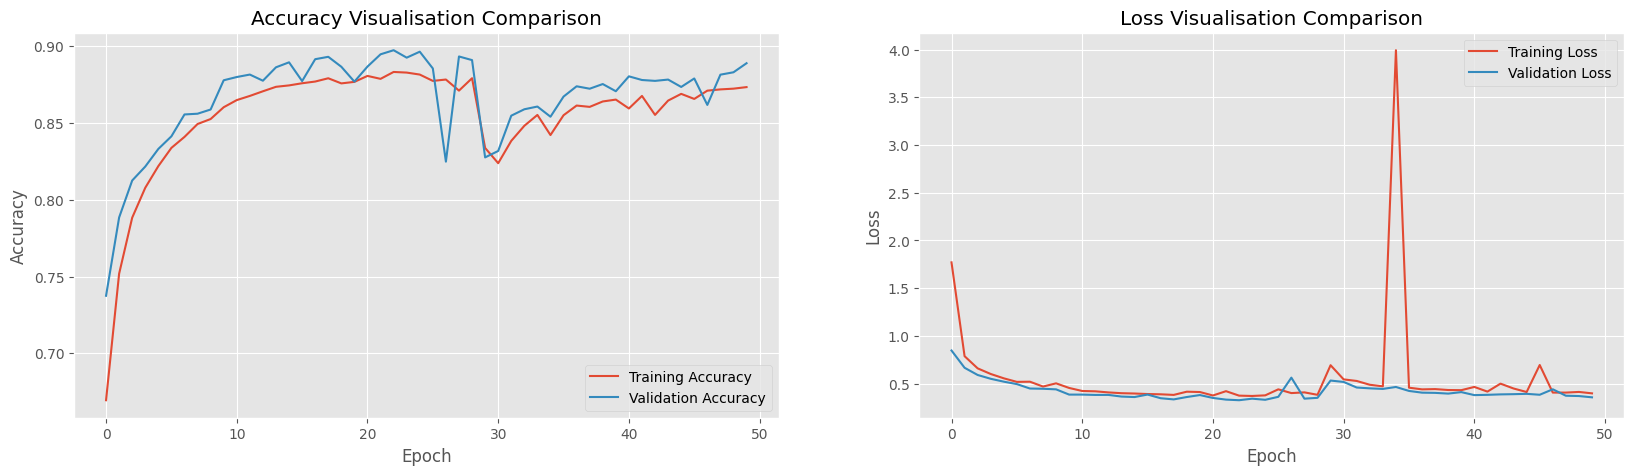

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
# get true & predict label
y_preds = model.predict(X_val).argmax(axis = 1)
y_true  = y_val.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = list_targets))

7479/7479 [==============================] - 16s 2ms/step
              precision    recall  f1-score   support

      Amazon       0.92      0.86      0.89     17414
     Dropbox       0.83      0.71      0.77      3852
    Facebook       0.87      0.88      0.88     24250
      Google       0.88      0.64      0.74      4060
         IMO       0.91      0.97      0.94    113975
   Instagram       1.00      1.00      1.00      4584
   Messenger       0.79      0.67      0.73      3168
   Microsoft       0.88      0.93      0.91      8974
       GMail       0.90      0.94      0.92     34512
       Skype       0.79      0.61      0.69      3316
   UbuntuONE       0.79      0.57      0.67      2215
    WhatsApp       0.95      0.89      0.92      3081
     Twitter       0.81      0.56      0.66      4732
     YouTube       0.84      0.59      0.69     11184

    accuracy                           0.90    239317
   macro avg       0.87      0.77      0.81    239317
weighted avg       0.8

In [ ]:
# define feature and target
feature = data_test.drop(['web_service', 'flow_key', 'category', 'application_protocol'], axis=1)
feature_num = feature[list_cols].values.astype("float32")
feature_cat = feature[categorical].values.astype("float32")
target  = data_test["web_service"]

In [ ]:
# apply scaling on feature distribution
# scaler = MinMaxScaler()
# scaler.fit(feature_num)
scaled_num = scaler.transform(feature_num)
feature_scaled = np.hstack((scaled_num, feature_cat))
feature_scaled = feature_scaled.reshape(feature_scaled.shape[0], feature_scaled.shape[1], 1)

In [ ]:
# encode label
# encoder = LabelEncoder()
target_encode = encoder.fit_transform(target.values)
target_categorical = to_categorical(target_encode)

In [ ]:
# get true & predict from validation dataset
y_preds = model.predict(feature_scaled).argmax(axis = 1)
y_true  = target_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = list_targets))

7475/7475 [==============================] - 16s 2ms/step
              precision    recall  f1-score   support

      Amazon       0.92      0.86      0.89     17502
     Dropbox       0.83      0.72      0.77      3772
    Facebook       0.87      0.88      0.88     24065
       GMail       0.89      0.64      0.74      4235
      Google       0.91      0.96      0.94    113877
         IMO       1.00      1.00      1.00      4667
   Instagram       0.80      0.69      0.74      3119
   Messenger       0.88      0.93      0.91      9041
   Microsoft       0.90      0.94      0.92     34724
       Skype       0.79      0.63      0.70      3134
     Twitter       0.78      0.55      0.64      2104
   UbuntuONE       0.96      0.89      0.92      3028
    WhatsApp       0.81      0.56      0.66      4731
     YouTube       0.83      0.60      0.70     11172

    accuracy                           0.90    239171
   macro avg       0.87      0.78      0.81    239171
weighted avg       0.9

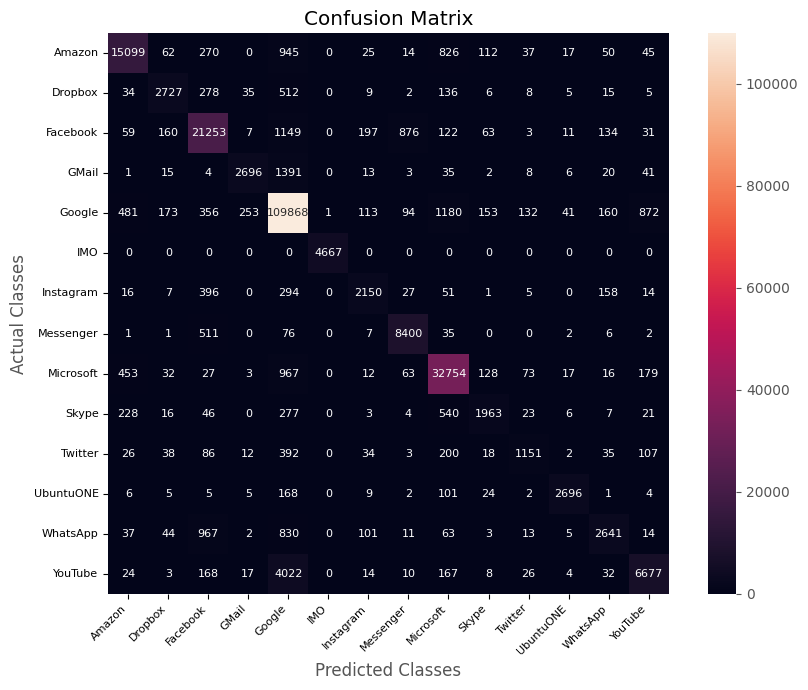

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

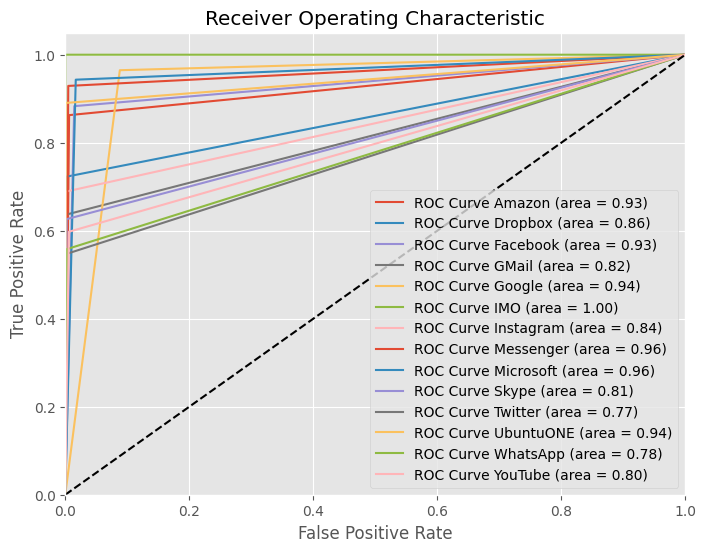

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 1.2. Dataset Undersampling Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_under2.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263825 entries, 0 to 263824
Data columns (total 40 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     263825 non-null  int64  
 1   src_port           263825 non-null  int64  
 2   dst_port           263825 non-null  int64  
 3   proto              263825 non-null  int64  
 4   pktTotalCount      263825 non-null  int64  
 5   octetTotalCount    263825 non-null  int64  
 6   min_ps             263825 non-null  int64  
 7   max_ps             263825 non-null  int64  
 8   avg_ps             263825 non-null  float64
 9   std_dev_ps         263825 non-null  float64
 10  flowStart          263825 non-null  float64
 11  flowEnd            263825 non-null  float64
 12  flowDuration       263825 non-null  float64
 13  min_piat           263825 non-null  float64
 14  max_piat           263825 non-null  float64
 15  avg_piat           263825 non-null  float64
 16  st

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Microsoft    30000
Amazon       30000
Google       30000
YouTube      30000
Facebook     30000
Messenger    27146
WhatsApp     14431
IMO          13783
GMail        12413
Dropbox      11680
Skype         9509
Instagram     9423
UbuntuONE     9067
Twitter       6373
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_num = train_feature[list_cols].values.astype("float32")
train_cat = train_feature[categorical].values.astype("float32")
train_target  = data["web_service"]

In [ ]:
# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_num = val_feature[list_cols].values.astype("float32")
val_cat = val_feature[categorical].values.astype("float32")
val_target  = data_val["web_service"]

In [ ]:
# apply scaling on feature distribution
scaler = MinMaxScaler()
scaler.fit(train_num)
X_train = scaler.transform(train_num)
X_train = np.hstack((X_train, train_cat))

X_val = scaler.transform(val_num)
X_val = np.hstack((X_val, val_cat))

In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target"
encoder = LabelEncoder()
y_train = encoder.fit(train_target.values)

y_train = encoder.transform(train_target.values)
y_val = encoder.transform(val_target.values)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:

# check dimension
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(263825, 37) (239175, 37) (263825, 14) (239175, 14)


In [ ]:
# reshape dimension for convolutional layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val  = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# re-check dimension
print(X_train.shape, X_val.shape)

(263825, 37, 1) (239175, 37, 1)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(Conv1D(512, 3, activation = "relu", input_shape = (X_train.shape[1], 1)))
  model.add(Conv1D(512, 3, activation = "relu"))
  model.add(MaxPooling1D(2, padding = "same"))
  model.add(Conv1D(256, 3, activation = "relu"))
  model.add(Conv1D(256, 3, activation = "relu"))
  model.add(MaxPooling1D(2, padding = "same"))
  # model.add(Conv1D(128, 3, activation = "relu"))
  # model.add(MaxPooling1D(2, padding = "same"))

  model.add(Flatten())

  model.add(Dropout(0.2))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(14, activation = "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = list_metrics)

  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 512)           2048      
                                                                 
 conv1d_1 (Conv1D)           (None, 33, 512)           786944    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17, 512)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 256)           393472    
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 256)           196864    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 256)           0         
 1D)                                                    

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/cnn_under2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
4119/4119 [==============================] - ETA: 0s - loss: 3.0845 - accuracy: 0.4339 - precision: 0.7078 - recall: 0.2361 - F1Score: 0.3377
Epoch 1: val_accuracy improved from -inf to 0.59546, saving model to /content/drive/MyDrive/07/Skripsi/Progress5/cnn_under2.h5
4119/4119 [==============================] - 69s 13ms/step - loss: 3.0845 - accuracy: 0.4339 - precision: 0.7078 - recall: 0.2361 - F1Score: 0.3377 - val_loss: 1.2728 - val_accuracy: 0.5955 - val_precision: 0.7467 - val_recall: 0.3498 - val_F1Score: 0.4748
Epoch 2/50
4115/4119 [============================>.] - ETA: 0s - loss: 1.2467 - accuracy: 0.5856 - precision: 0.7586 - recall: 0.4317 - F1Score: 0.5482
Epoch 2: val_accuracy improved from 0.59546 to 0.61277, saving model to /content/drive/MyDrive/07/Skripsi/Progress5/cnn_under2.h5
4119/4119 [==============================] - 58s 14ms/step - loss: 1.2466 - accuracy: 0.5856 - precision: 0.7586 - recall: 0.4317 - F1Score: 0.5482 - val_loss: 1.1623 - val_accurac

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/cnn_under2.h5")

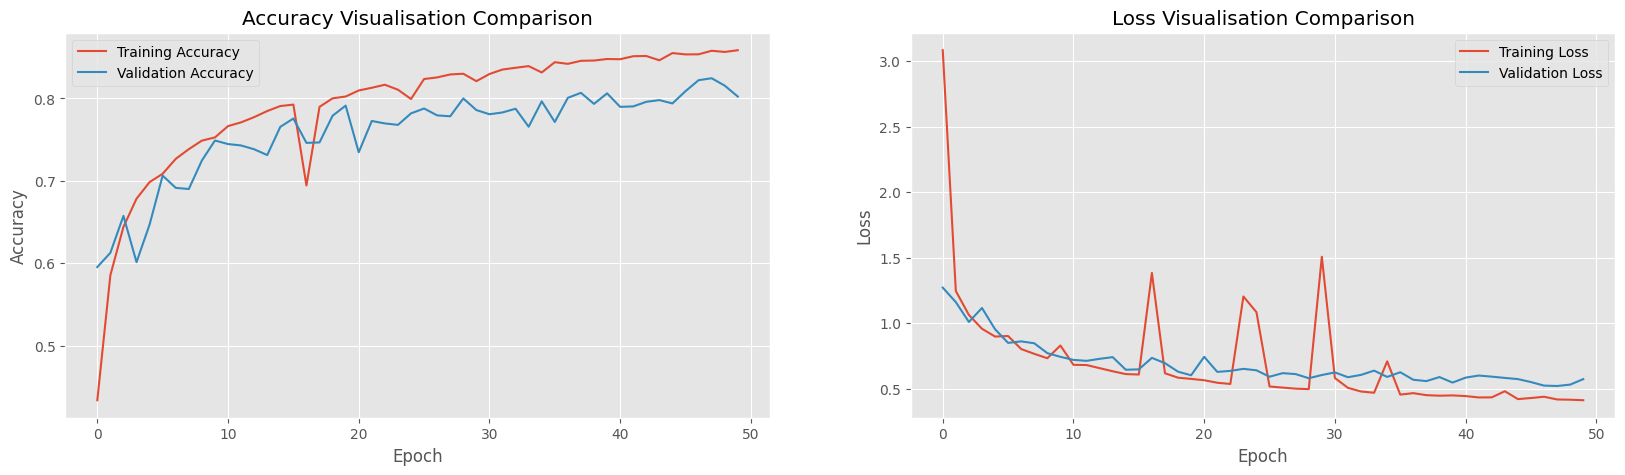

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
# get true & predict label
y_preds = model.predict(X_val).argmax(axis = 1)
y_true  = y_val.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = list_targets))

7479/7479 [==============================] - 15s 2ms/step
              precision    recall  f1-score   support

      Amazon       0.81      0.92      0.86     17414
     Dropbox       0.61      0.82      0.70      3852
    Facebook       0.85      0.86      0.86     24250
      Google       0.47      0.88      0.61      4060
         IMO       0.96      0.76      0.85    113975
   Instagram       1.00      1.00      1.00      4584
   Messenger       0.57      0.82      0.67      3168
   Microsoft       0.89      0.98      0.94      8974
       GMail       0.92      0.90      0.91     34512
       Skype       0.56      0.81      0.66      3316
   UbuntuONE       0.60      0.69      0.64      2215
    WhatsApp       0.85      0.94      0.89      3081
     Twitter       0.59      0.68      0.63      4732
     YouTube       0.42      0.83      0.56     11184

    accuracy                           0.82    239317
   macro avg       0.72      0.85      0.77    239317
weighted avg       0.8

In [ ]:
# check dimension
data_test.shape

(239171, 44)

In [ ]:
# define feature and target
feature = data_test.drop(['web_service', 'flow_key', 'category', 'application_protocol'], axis=1)
feature_num = feature[list_cols].values.astype("float32")
feature_cat = feature[categorical].values.astype("float32")
target  = data_test["web_service"]

In [ ]:
# apply scaling on feature distribution
# scaler = MinMaxScaler()
# scaler.fit(feature_num)
scaled_num = scaler.transform(feature_num)
feature_scaled = np.hstack((scaled_num, feature_cat))
feature_scaled = feature_scaled.reshape(feature_scaled.shape[0], feature_scaled.shape[1], 1)

In [ ]:
# encode label
# encoder = LabelEncoder()
target_encode = encoder.fit_transform(target.values)
target_categorical = to_categorical(target_encode)

In [ ]:
# check dimension
feature_scaled.shape, target_categorical.shape

((239171, 37, 1), (239171, 14))

In [ ]:
# get true & predict from validation dataset
y_preds = model.predict(feature_scaled).argmax(axis = 1)
y_true  = target_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = list_targets))

7475/7475 [==============================] - 27s 4ms/step
              precision    recall  f1-score   support

      Amazon       0.80      0.92      0.86     17502
     Dropbox       0.60      0.82      0.69      3772
    Facebook       0.86      0.86      0.86     24065
       GMail       0.47      0.87      0.61      4235
      Google       0.96      0.76      0.85    113877
         IMO       1.00      1.00      1.00      4667
   Instagram       0.57      0.84      0.68      3119
   Messenger       0.89      0.98      0.94      9041
   Microsoft       0.92      0.90      0.91     34724
       Skype       0.55      0.82      0.66      3134
     Twitter       0.57      0.70      0.63      2104
   UbuntuONE       0.84      0.94      0.89      3028
    WhatsApp       0.60      0.67      0.63      4731
     YouTube       0.42      0.84      0.56     11172

    accuracy                           0.83    239171
   macro avg       0.72      0.85      0.77    239171
weighted avg       0.8

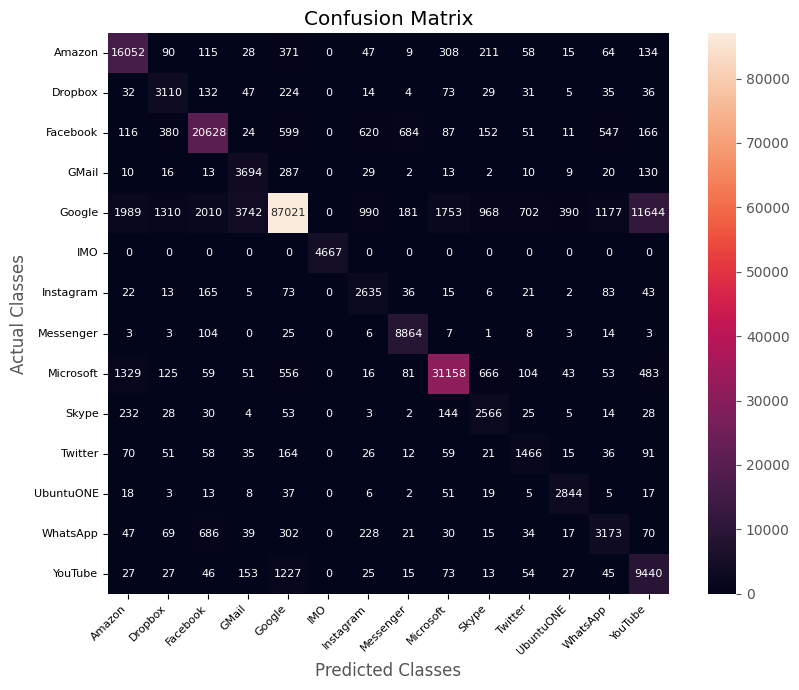

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

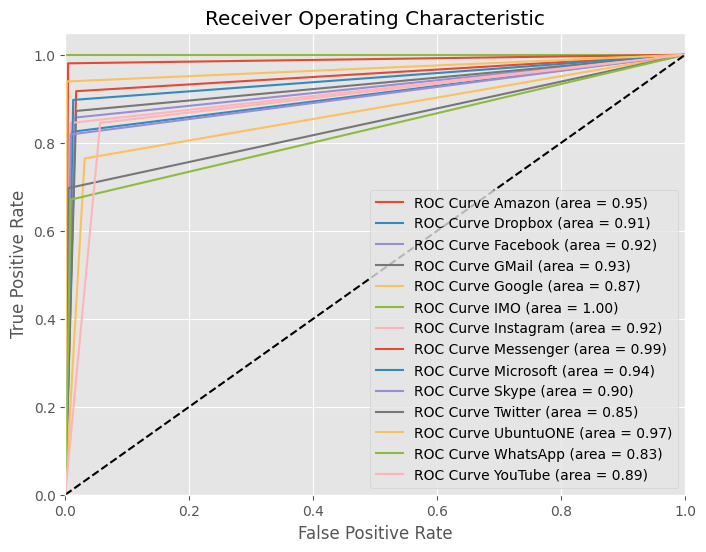

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 1.3. Dataset Oversampling Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_over2.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795700 entries, 0 to 795699
Data columns (total 40 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     795700 non-null  int64  
 1   src_port           795700 non-null  int64  
 2   dst_port           795700 non-null  int64  
 3   proto              795700 non-null  int64  
 4   pktTotalCount      795700 non-null  int64  
 5   octetTotalCount    795700 non-null  int64  
 6   min_ps             795700 non-null  int64  
 7   max_ps             795700 non-null  int64  
 8   avg_ps             795700 non-null  float64
 9   std_dev_ps         795700 non-null  float64
 10  flowStart          795700 non-null  float64
 11  flowEnd            795700 non-null  float64
 12  flowDuration       795700 non-null  float64
 13  min_piat           795700 non-null  float64
 14  max_piat           795700 non-null  float64
 15  avg_piat           795700 non-null  float64
 16  st

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Google       341434
Microsoft    103674
Facebook      72482
Amazon        52733
YouTube       33377
Messenger     32000
IMO           26000
WhatsApp      26000
Dropbox       22000
GMail         22000
Skype         18000
Instagram     18000
UbuntuONE     16000
Twitter       12000
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_num = train_feature[list_cols].values.astype("float32")
train_cat = train_feature[categorical].values.astype("float32")
train_target  = data["web_service"]

In [ ]:

# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_num = val_feature[list_cols].values.astype("float32")
val_cat = val_feature[categorical].values.astype("float32")
val_target  = data_val["web_service"]

In [ ]:
# apply scaling on feature distribution
scaler = MinMaxScaler()
scaler.fit(train_num)
X_train = scaler.transform(train_num)
X_train = np.hstack((X_train, train_cat))

X_val = scaler.transform(val_num)
X_val = np.hstack((X_val, val_cat))

In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target"
encoder = LabelEncoder()
y_train = encoder.fit(train_target.values)

y_train = encoder.transform(train_target.values)
y_val = encoder.transform(val_target.values)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
# reshape dimension for convolutional layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val  = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# re-check dimension
print(X_train.shape, X_val.shape)

(795700, 37, 1) (239175, 37, 1)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(Conv1D(512, 3, activation = "relu", input_shape = (X_train.shape[1], 1)))
  model.add(Conv1D(512, 3, activation = "relu"))
  model.add(MaxPooling1D(2, padding = "same"))
  model.add(Conv1D(256, 3, activation = "relu"))
  model.add(Conv1D(256, 3, activation = "relu"))
  model.add(MaxPooling1D(2, padding = "same"))
  # model.add(Conv1D(128, 3, activation = "relu"))
  # model.add(MaxPooling1D(2, padding = "same"))

  model.add(Flatten())

  model.add(Dropout(0.2))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(14, activation = "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = list_metrics)

  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 35, 512)           2048      
                                                                 
 conv1d_5 (Conv1D)           (None, 33, 512)           786944    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 17, 512)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 15, 256)           393472    
                                                                 
 conv1d_7 (Conv1D)           (None, 13, 256)           196864    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 7, 256)           0         
 1D)                                                  

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/cnn_over.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
12435/12435 [==============================] - ETA: 0s - loss: 1.7044 - accuracy: 0.6401 - precision_1: 0.7399 - recall_1: 0.5156 - F1Score: 0.6000
Epoch 1: val_accuracy improved from -inf to 0.74824, saving model to /content/drive/MyDrive/07/Skripsi/Progress6/cnn_over.h5
12435/12435 [==============================] - 140s 10ms/step - loss: 1.7044 - accuracy: 0.6401 - precision_1: 0.7399 - recall_1: 0.5156 - F1Score: 0.6000 - val_loss: 0.7820 - val_accuracy: 0.7482 - val_precision_1: 0.8117 - val_recall_1: 0.6802 - val_F1Score: 0.7396
Epoch 2/50
12430/12435 [============================>.] - ETA: 0s - loss: 0.8176 - accuracy: 0.7352 - precision_1: 0.8044 - recall_1: 0.6658 - F1Score: 0.7278
Epoch 2: val_accuracy improved from 0.74824 to 0.79551, saving model to /content/drive/MyDrive/07/Skripsi/Progress6/cnn_over.h5
12435/12435 [==============================] - 135s 11ms/step - loss: 0.8176 - accuracy: 0.7352 - precision_1: 0.8043 - recall_1: 0.6657 - F1Score: 0.7278 - val_

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/cnn_over.h5")

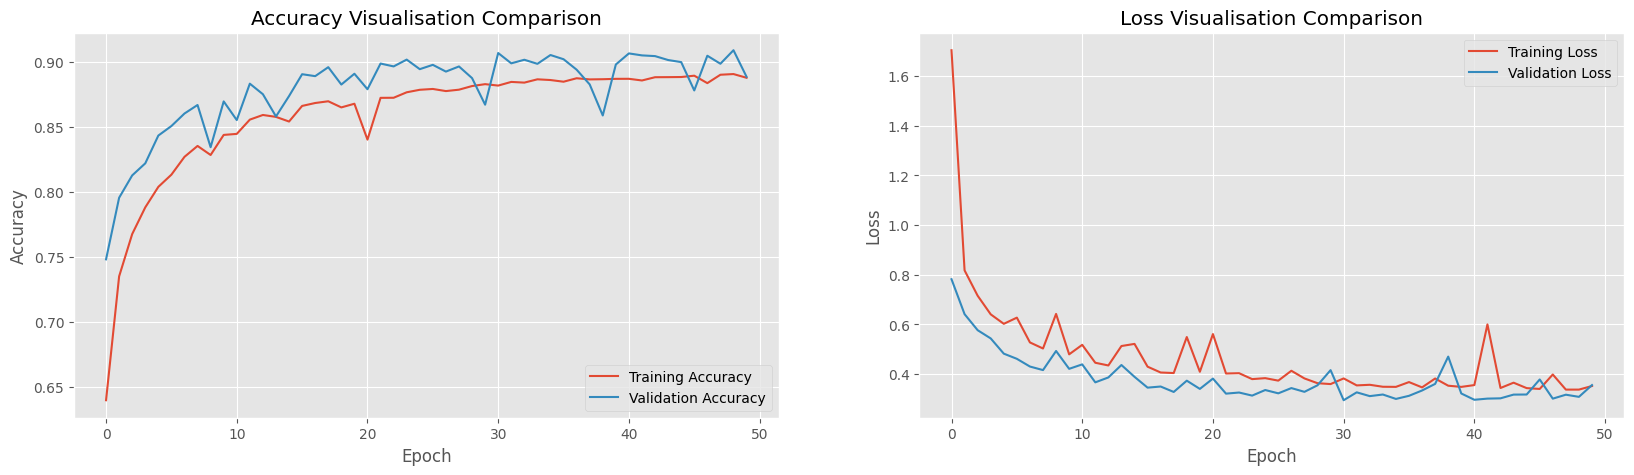

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
# get true & predict label
y_preds = model.predict(X_val).argmax(axis = 1)
y_true  = y_val.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = list_targets))

7479/7479 [==============================] - 15s 2ms/step
              precision    recall  f1-score   support

      Amazon       0.92      0.88      0.90     17414
     Dropbox       0.76      0.81      0.79      3852
    Facebook       0.91      0.88      0.89     24250
      Google       0.83      0.73      0.78      4060
         IMO       0.92      0.97      0.94    113975
   Instagram       1.00      1.00      1.00      4584
   Messenger       0.77      0.75      0.76      3168
   Microsoft       0.91      0.96      0.94      8974
       GMail       0.94      0.94      0.94     34512
       Skype       0.80      0.72      0.76      3316
   UbuntuONE       0.69      0.74      0.71      2215
    WhatsApp       0.92      0.92      0.92      3081
     Twitter       0.77      0.68      0.72      4732
     YouTube       0.88      0.60      0.71     11184

    accuracy                           0.91    239317
   macro avg       0.86      0.83      0.84    239317
weighted avg       0.9

In [ ]:
is# check dimension
data_test.shape

(239171, 44)

In [ ]:
# define feature and target
feature = data_test.drop(['web_service', 'flow_key', 'category', 'application_protocol'], axis=1)
feature_num = feature[list_cols].values.astype("float32")
feature_cat = feature[categorical].values.astype("float32")
target  = data_test["web_service"]

In [ ]:
# apply scaling on feature distribution
# scaler = MinMaxScaler()
# scaler.fit(feature_num)
scaled_num = scaler.transform(feature_num)
feature_scaled = np.hstack((scaled_num, feature_cat))
feature_scaled = feature_scaled.reshape(feature_scaled.shape[0], feature_scaled.shape[1], 1)

In [ ]:
# encode label
# encoder = LabelEncoder()
target_encode = encoder.fit_transform(target.values)
target_categorical = to_categorical(target_encode)

In [ ]:
# check dimension
feature_scaled.shape, target_categorical.shape

((239171, 37, 1), (239171, 14))

In [ ]:
# get true & predict from validation dataset
y_preds = model.predict(feature_scaled).argmax(axis = 1)
y_true  = target_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = list_targets))

7475/7475 [==============================] - 15s 2ms/step
              precision    recall  f1-score   support

      Amazon       0.92      0.88      0.90     17502
     Dropbox       0.76      0.82      0.79      3772
    Facebook       0.91      0.88      0.90     24065
       GMail       0.84      0.73      0.78      4235
      Google       0.92      0.97      0.94    113877
         IMO       1.00      1.00      1.00      4667
   Instagram       0.76      0.77      0.77      3119
   Messenger       0.92      0.96      0.94      9041
   Microsoft       0.94      0.94      0.94     34724
       Skype       0.78      0.73      0.76      3134
     Twitter       0.68      0.73      0.71      2104
   UbuntuONE       0.93      0.93      0.93      3028
    WhatsApp       0.77      0.68      0.72      4731
     YouTube       0.88      0.61      0.72     11172

    accuracy                           0.91    239171
   macro avg       0.86      0.83      0.84    239171
weighted avg       0.9

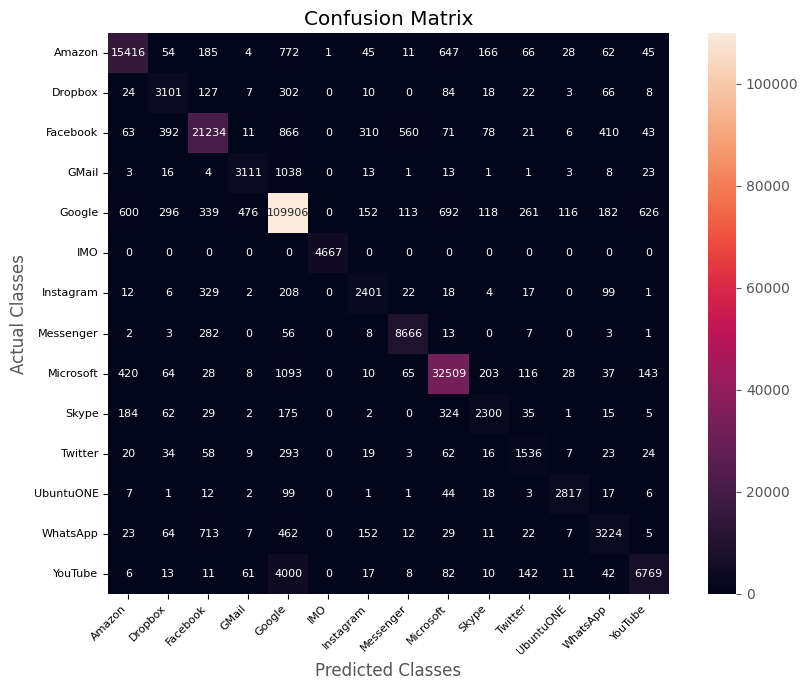

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

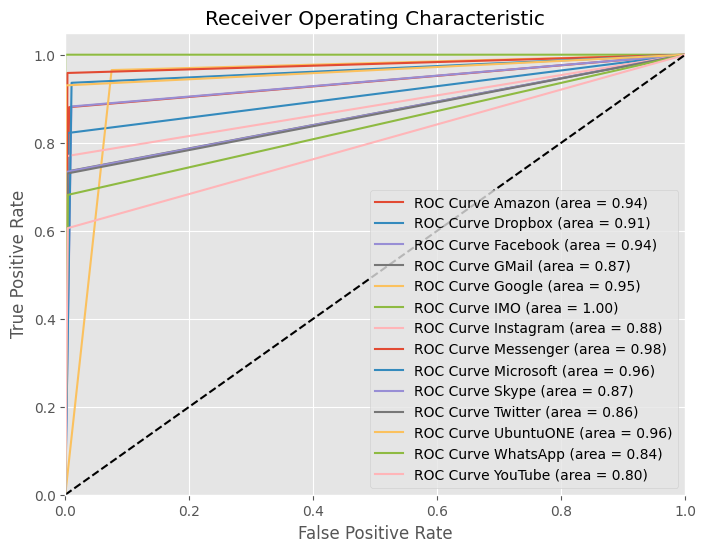

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 2. LSTM

In [ ]:
# load libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Dense, BatchNormalization, LSTM, Dropout, Flatten,
    MaxPooling1D, SpatialDropout1D, GRU, Bidirectional
    )

In [ ]:
# setup backend of  visualisation
plt.style.use("ggplot")

In [ ]:
# define f1-score metrics
def F1Score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# define list_metrics used for iterate learning
list_metrics = ["accuracy", Precision(), Recall(), F1Score]

# define global variable for training model
EPOCHS = 50
BATCH_SIZE = 64
TIME_PERIODS = 150
STEP_DISTANCE = 20

In [ ]:
def create_sequences(df, target_var, seq_length=TIME_PERIODS, step=STEP_DISTANCE):

    def get_sequence_label(seq_df):
        return seq_df[target_var].mode()[0]

    sequences = []
    labels = []

    for i in tqdm(range(0, len(df) - seq_length + 1, step)):
        seq_df = df.iloc[i:i+seq_length]

        if len(seq_df) == seq_length:
            sequences.append(seq_df.drop(columns=[target_var]).values)
            labels.append(get_sequence_label(seq_df))

    sequences = np.array(sequences)
    labels = np.array(labels)

    return sequences, labels


In [ ]:
# load test dataset
data_test = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_test.csv")

In [ ]:
data_val = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_val.csv")

In [ ]:
list_cols = [ "pktTotalCount", "octetTotalCount", "min_ps", "max_ps", "avg_ps",
    "std_dev_ps", "flowStart", "flowEnd", "flowDuration",
    "min_piat", "max_piat", "avg_piat", "std_dev_piat", "f_pktTotalCount",
"f_octetTotalCount", "f_max_ps", "f_avg_ps", "f_std_dev_ps", "f_min_piat",
"f_max_piat", "f_avg_piat", "f_std_dev_piat", "b_pktTotalCount",
 "b_octetTotalCount", "b_max_ps", "b_avg_ps", "b_std_dev_ps", "b_min_piat",
"b_max_piat", "b_avg_piat", "b_std_dev_piat",]

categorical = ["src_ip_numeric", "dst_ip_numeric", "src_port", "dst_port", "proto", "flowEndReason" ]

# define clasas "web_service" based Pre-Preprocessing notebook
list_targets = [
    "Amazon", "Dropbox", "Facebook", "GMail", "Google", "IMO",
    "Instagram", "Messenger", "Microsoft",
    "Skype","Twitter", "UbuntuONE", "WhatsApp",  "YouTube"
]


## 2.1. Dataset Normal Distribution



In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_norm.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717525 entries, 222409 to 197752
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     717525 non-null  int64  
 1   src_port           717525 non-null  int64  
 2   dst_port           717525 non-null  int64  
 3   proto              717525 non-null  int64  
 4   pktTotalCount      717525 non-null  int64  
 5   octetTotalCount    717525 non-null  int64  
 6   min_ps             717525 non-null  int64  
 7   max_ps             717525 non-null  int64  
 8   avg_ps             717525 non-null  float64
 9   std_dev_ps         717525 non-null  float64
 10  flowStart          717525 non-null  float64
 11  flowEnd            717525 non-null  float64
 12  flowDuration       717525 non-null  float64
 13  min_piat           717525 non-null  float64
 14  max_piat           717525 non-null  float64
 15  avg_piat           717525 non-null  float64
 1

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Google       341434
Microsoft    103674
Facebook      72482
Amazon        52733
YouTube       33377
Messenger     27146
WhatsApp      14431
IMO           13783
GMail         12413
Dropbox       11680
Skype          9509
Instagram      9423
UbuntuONE      9067
Twitter        6373
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_target  = data["web_service"]

In [ ]:
# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_target  = data_val["web_service"]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_feature[list_cols])
train_feature[list_cols] = scaler.transform(train_feature[list_cols])
train_scaled = pd.concat([train_feature[list_cols], train_feature[categorical], train_target], axis=1)

val_feature[list_cols] = scaler.transform(val_feature[list_cols])
val_scaled = pd.concat([val_feature[list_cols], val_feature[categorical], val_target], axis=1)

In [ ]:
# Create the sequences and labels using the `create_sequences` function
train_segment, train_label = create_sequences(train_scaled, 'web_service')

100%|██████████| 35869/35869 [00:35<00:00, 1010.05it/s]


In [ ]:
# apply sequence segmentation on dataset
val_segment, val_label = create_sequences(val_scaled, 'web_service')

# check dimension
print(val_segment.shape, val_label.shape)

100%|██████████| 11952/11952 [00:17<00:00, 669.72it/s] 


(11952, 150, 37) (11952,)


In [ ]:
import numpy as np

unique, counts = np.unique(train_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '2633']
 ['Dropbox' '584']
 ['Facebook' '3625']
 ['GMail' '620']
 ['Google' '17072']
 ['IMO' '689']
 ['Instagram' '471']
 ['Messenger' '1357']
 ['Microsoft' '5184']
 ['Skype' '476']
 ['Twitter' '318']
 ['UbuntuONE' '454']
 ['WhatsApp' '721']
 ['YouTube' '1665']]


In [ ]:
import numpy as np

unique, counts = np.unique(val_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '874']
 ['Dropbox' '187']
 ['Facebook' '1203']
 ['GMail' '207']
 ['Google' '5705']
 ['IMO' '231']
 ['Instagram' '153']
 ['Messenger' '451']
 ['Microsoft' '1724']
 ['Skype' '158']
 ['Twitter' '109']
 ['UbuntuONE' '155']
 ['WhatsApp' '236']
 ['YouTube' '559']]


In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target" variable
encoder = LabelEncoder()
encoder.fit(train_target.values)

# apply on train-val segmented label
train_label_encode = encoder.transform(train_label)
train_categorical  = to_categorical(train_label_encode)
val_label_encode  = encoder.transform(val_label)
val_categorical  = to_categorical(val_label_encode)

# check dimension
print(train_categorical.shape, val_categorical.shape)

(35869, 14) (11952, 14)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(LSTM(512, input_shape = (train_segment.shape[1], train_segment.shape[2]), return_sequences=True))
  model.add(LSTM(256))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(14, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=list_metrics)
  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 512)          1126400   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 1,983,246
Trainable params: 1,983,246
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/lstm_norm2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    train_segment, train_categorical,
    validation_data = (val_segment, val_categorical),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
560/561 [============================>.] - ETA: 0s - loss: 0.5222 - accuracy: 0.8509 - precision: 0.8854 - recall: 0.8178 - F1Score: 0.8451
Epoch 1: val_accuracy improved from -inf to 0.81501, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/lstm_norm2.h5
561/561 [==============================] - 42s 58ms/step - loss: 0.5218 - accuracy: 0.8510 - precision: 0.8854 - recall: 0.8179 - F1Score: 0.8453 - val_loss: 0.6999 - val_accuracy: 0.8150 - val_precision: 0.8341 - val_recall: 0.7866 - val_F1Score: 0.8043
Epoch 2/50
560/561 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.9132 - precision: 0.9229 - recall: 0.9040 - F1Score: 0.9132
Epoch 2: val_accuracy improved from 0.81501 to 0.91801, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/lstm_norm2.h5
561/561 [==============================] - 31s 56ms/step - loss: 0.2954 - accuracy: 0.9132 - precision: 0.9229 - recall: 0.9040 - F1Score: 0.9132 - val_loss: 0.2646 - val_accuracy: 0.918

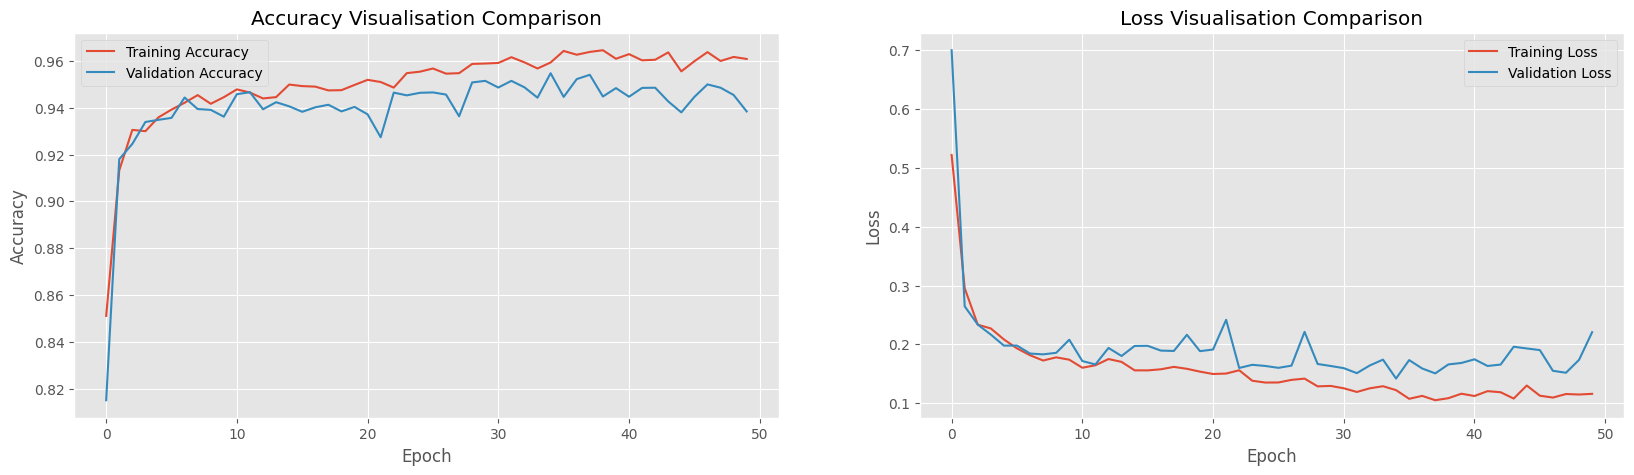

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/lstm_norm2.h5")

In [ ]:
# get true & predict label
y_preds = model.predict(val_segment).argmax(axis = 1)
y_true  = val_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       874
     Dropbox       0.98      0.95      0.96       187
    Facebook       0.95      1.00      0.97      1203
       GMail       0.80      0.44      0.57       207
      Google       0.96      0.99      0.97      5705
         IMO       0.96      0.98      0.97       231
   Instagram       0.64      0.95      0.77       153
   Messenger       0.93      0.78      0.85       451
   Microsoft       1.00      1.00      1.00      1724
       Skype       0.99      0.99      0.99       158
     Twitter       0.93      0.13      0.23       109
   UbuntuONE       0.99      0.99      0.99       155
    WhatsApp       0.78      0.60      0.68       236
     YouTube       0.94      0.90      0.92       559

    accuracy                           0.95     11952
   macro avg       0.92      0.84      0.85     11952
weighted avg       0.95 

In [ ]:
# check dimension
data_test.shape

(239175, 43)

In [ ]:
# define feature and target
test_feature = data_test.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
test_target  = data_test["web_service"]

scaler = MinMaxScaler()
test_feature[list_cols] = scaler.fit_transform(test_feature[list_cols])
test_scaled = pd.concat([test_feature[list_cols], test_feature[categorical], test_target], axis=1)

In [ ]:
# Create the sequences and labels using the `create_sequences` function
test_segment, test_label = create_sequences(test_scaled, 'web_service')

100%|██████████| 11952/11952 [00:11<00:00, 1066.97it/s]


In [ ]:
import numpy as np

unique, counts = np.unique(test_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '862']
 ['Dropbox' '190']
 ['Facebook' '1216']
 ['GMail' '209']
 ['Google' '5715']
 ['IMO' '222']
 ['Instagram' '159']
 ['Messenger' '450']
 ['Microsoft' '1712']
 ['Skype' '163']
 ['Twitter' '104']
 ['UbuntuONE' '160']
 ['WhatsApp' '233']
 ['YouTube' '557']]


In [ ]:
encoder = LabelEncoder()

# encode label
target_encode = encoder.fit_transform(test_label)
test_categorical = to_categorical(target_encode)

In [ ]:
# check dimension
test_segment.shape, test_categorical.shape

((11952, 150, 37), (11952, 14))

In [ ]:
# get true & predict label from validation dataset
y_preds = model.predict(test_segment).argmax(axis = 1)
y_true  = test_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 6s 12ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       862
     Dropbox       0.94      0.97      0.96       190
    Facebook       0.95      1.00      0.97      1216
       GMail       0.77      0.35      0.48       209
      Google       0.96      0.99      0.97      5715
         IMO       0.99      0.98      0.98       222
   Instagram       0.75      0.99      0.85       159
   Messenger       0.95      0.82      0.88       450
   Microsoft       1.00      1.00      1.00      1712
       Skype       0.99      0.99      0.99       163
     Twitter       0.75      0.23      0.35       104
   UbuntuONE       0.99      0.99      0.99       160
    WhatsApp       0.77      0.64      0.70       233
     YouTube       0.93      0.95      0.94       557

    accuracy                           0.96     11952
   macro avg       0.91      0.85      0.86     11952
weighted avg       0.95 

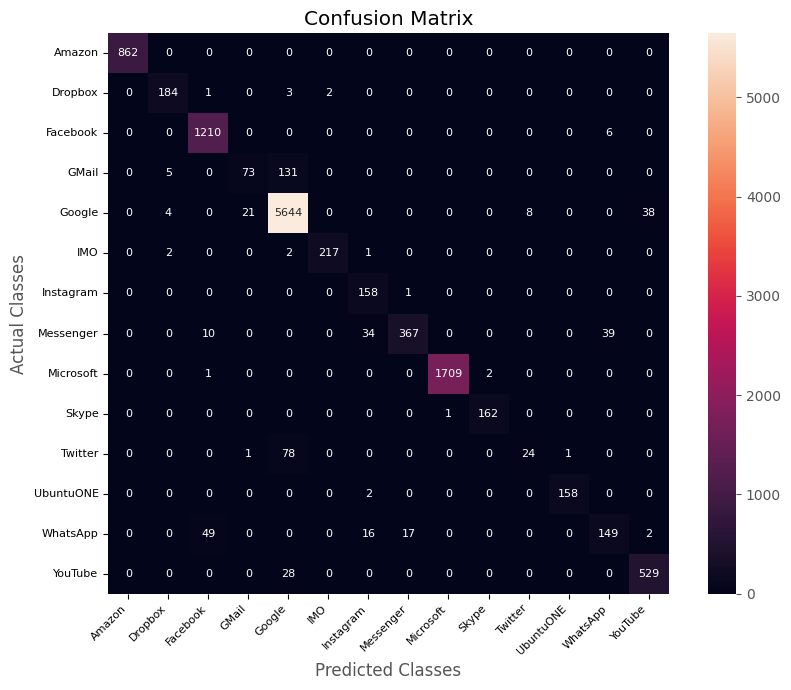

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

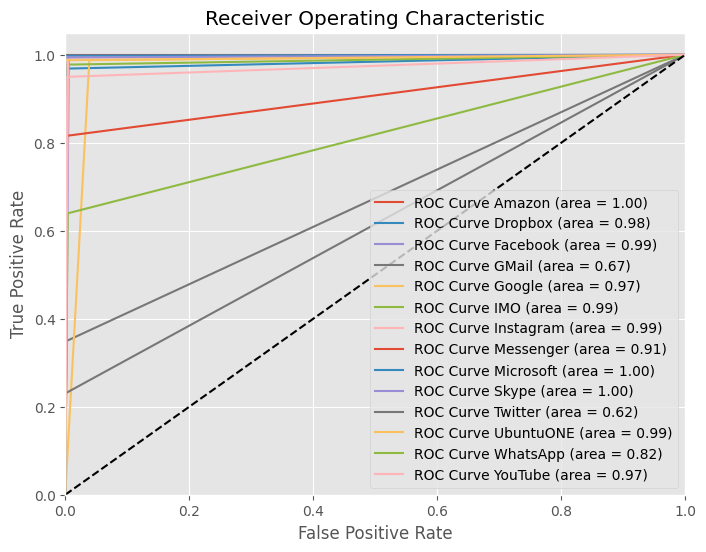

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 2.2. Dataset Undersampling Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_under2.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263825 entries, 51145 to 102290
Data columns (total 40 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     263825 non-null  int64  
 1   src_port           263825 non-null  int64  
 2   dst_port           263825 non-null  int64  
 3   proto              263825 non-null  int64  
 4   pktTotalCount      263825 non-null  int64  
 5   octetTotalCount    263825 non-null  int64  
 6   min_ps             263825 non-null  int64  
 7   max_ps             263825 non-null  int64  
 8   avg_ps             263825 non-null  float64
 9   std_dev_ps         263825 non-null  float64
 10  flowStart          263825 non-null  float64
 11  flowEnd            263825 non-null  float64
 12  flowDuration       263825 non-null  float64
 13  min_piat           263825 non-null  float64
 14  max_piat           263825 non-null  float64
 15  avg_piat           263825 non-null  float64
 16

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Amazon       30000
Facebook     30000
Google       30000
Microsoft    30000
YouTube      30000
Messenger    27146
WhatsApp     14431
IMO          13783
GMail        12413
Dropbox      11680
Skype         9509
Instagram     9423
UbuntuONE     9067
Twitter       6373
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_target  = data["web_service"]

In [ ]:
# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_target  = data_val["web_service"]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_feature[list_cols])
train_feature[list_cols] = scaler.transform(train_feature[list_cols])
train_scaled = pd.concat([train_feature[list_cols], train_feature[categorical], train_target], axis=1)

val_feature[list_cols] = scaler.transform(val_feature[list_cols])
val_scaled = pd.concat([val_feature[list_cols], val_feature[categorical], val_target], axis=1)

In [ ]:
# apply sequence segmentation on dataset
train_segment, train_label = create_sequences(train_scaled,'web_service')

# check dimension
print(train_segment.shape, train_label.shape)

100%|██████████| 13184/13184 [00:20<00:00, 636.71it/s]


(13184, 150, 37) (13184,)


In [ ]:
# apply sequence segmentation on dataset
val_segment, val_label = create_sequences(val_scaled,'web_service')

# check dimension
print(val_segment.shape, val_label.shape)

100%|██████████| 11952/11952 [00:15<00:00, 789.59it/s]


(11952, 150, 37) (11952,)


In [ ]:
import numpy as np

unique, counts = np.unique(train_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '1497']
 ['Dropbox' '584']
 ['Facebook' '1500']
 ['GMail' '620']
 ['Google' '1500']
 ['IMO' '690']
 ['Instagram' '471']
 ['Messenger' '1357']
 ['Microsoft' '1500']
 ['Skype' '475']
 ['Twitter' '319']
 ['UbuntuONE' '453']
 ['WhatsApp' '722']
 ['YouTube' '1496']]


In [ ]:
import numpy as np

unique, counts = np.unique(val_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '874']
 ['Dropbox' '187']
 ['Facebook' '1203']
 ['GMail' '207']
 ['Google' '5705']
 ['IMO' '231']
 ['Instagram' '153']
 ['Messenger' '451']
 ['Microsoft' '1724']
 ['Skype' '158']
 ['Twitter' '109']
 ['UbuntuONE' '155']
 ['WhatsApp' '236']
 ['YouTube' '559']]


In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target" variable
encoder = LabelEncoder()
encoder.fit(train_target.values)

# apply on train-test segmented label
train_label_encode = encoder.transform(train_label)
train_categorical  = to_categorical(train_label_encode)
val_label_encode  = encoder.transform(val_label)
val_categorical  = to_categorical(val_label_encode)

# check dimension
print(train_categorical.shape, val_categorical.shape)

(13184, 14) (11952, 14)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(LSTM(512, input_shape = (train_segment.shape[1], train_segment.shape[2]), return_sequences=True))
  model.add(LSTM(256))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(14, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=list_metrics)
  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150, 512)          1126400   
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 14)                3598      
                                                                 
Total params: 1,983,246
Trainable params: 1,983,246
Non-trainable params: 0
_________________________________________________________________


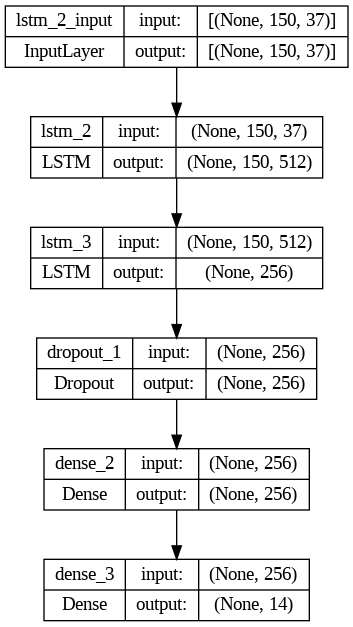

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/lstm_under.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    train_segment, train_categorical,
    validation_data = (val_segment, val_categorical),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
206/206 [==============================] - ETA: 0s - loss: 1.5057 - accuracy: 0.4657 - precision: 0.8666 - recall: 0.5734 - F1Score: 0.3499
Epoch 1: val_accuracy improved from -inf to 0.45013, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/lstm_under.h5
206/206 [==============================] - 19s 74ms/step - loss: 1.5057 - accuracy: 0.4657 - precision: 0.8666 - recall: 0.5734 - F1Score: 0.3499 - val_loss: 1.4894 - val_accuracy: 0.4501 - val_precision: 0.7517 - val_recall: 0.2574 - val_F1Score: 0.2985
Epoch 2/50
206/206 [==============================] - ETA: 0s - loss: 1.2611 - accuracy: 0.5388 - precision: 0.7019 - recall: 0.3471 - F1Score: 0.4598
Epoch 2: val_accuracy improved from 0.45013 to 0.46327, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/lstm_under.h5
206/206 [==============================] - 16s 77ms/step - loss: 1.2611 - accuracy: 0.5388 - precision: 0.7019 - recall: 0.3471 - F1Score: 0.4598 - val_loss: 1.2081 - val_accuracy: 0.463

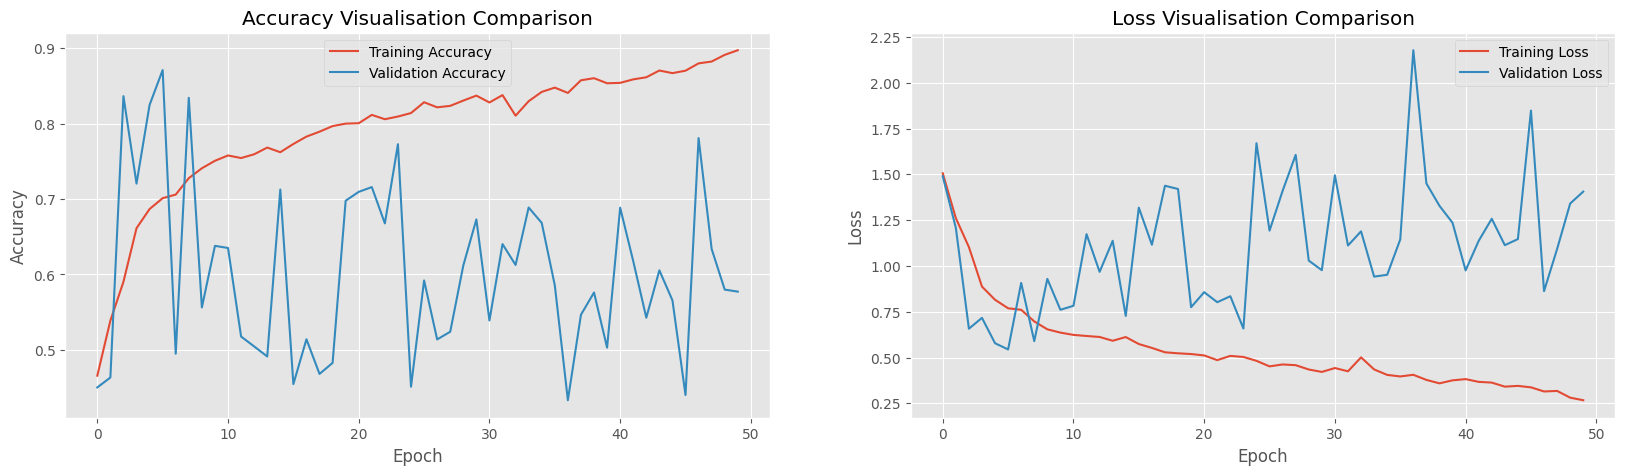

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")


plt.show()

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/lstm_under.h5")

In [ ]:
# get true & predict label
y_preds = model.predict(val_segment).argmax(axis = 1)
y_true  = val_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       874
     Dropbox       0.97      0.48      0.64       187
    Facebook       0.97      0.83      0.90      1203
       GMail       0.55      0.32      0.40       207
      Google       0.87      0.96      0.91      5705
         IMO       1.00      0.97      0.98       231
   Instagram       0.82      0.85      0.83       153
   Messenger       0.63      0.88      0.74       451
   Microsoft       0.99      1.00      1.00      1724
       Skype       1.00      0.92      0.96       158
     Twitter       0.00      0.00      0.00       109
   UbuntuONE       0.99      0.99      0.99       155
    WhatsApp       0.48      0.49      0.48       236
     YouTube       0.14      0.07      0.10       559

    accuracy                           0.87     11952
   macro avg       0.74      0.70      0.71     11952
weighted avg       0.85 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# check dimension
data_test.shape

(239175, 43)

In [ ]:
# define feature and target
test_feature = data_test.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
test_target  = data_test["web_service"]

# scaler = MinMaxScaler()
test_feature[list_cols] = scaler.transform(test_feature[list_cols])
test_scaled = pd.concat([test_feature[list_cols], test_feature[categorical], test_target], axis=1)

In [ ]:

# preprocess feature using sequence method
test_segment, test_label = create_sequences(test_scaled, 'web_service')

# encode label
# encoder = LabelEncoder()
target_encode = encoder.fit_transform(test_label)
test_categorical = to_categorical(target_encode)

100%|██████████| 11952/11952 [00:10<00:00, 1190.88it/s]


In [ ]:
import numpy as np

unique, counts = np.unique(test_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '862']
 ['Dropbox' '190']
 ['Facebook' '1216']
 ['GMail' '209']
 ['Google' '5715']
 ['IMO' '222']
 ['Instagram' '159']
 ['Messenger' '450']
 ['Microsoft' '1712']
 ['Skype' '163']
 ['Twitter' '104']
 ['UbuntuONE' '160']
 ['WhatsApp' '233']
 ['YouTube' '557']]


In [ ]:
# check dimension
test_segment.shape, test_categorical.shape

((11952, 150, 37), (11952, 14))

In [ ]:
# get true & predict label from validation dataset
y_preds = model.predict(test_segment).argmax(axis = 1)
y_true  = test_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 5s 13ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       862
     Dropbox       0.95      0.37      0.53       190
    Facebook       0.97      0.84      0.90      1216
       GMail       0.52      0.28      0.36       209
      Google       0.87      0.96      0.91      5715
         IMO       0.96      0.92      0.94       222
   Instagram       0.75      0.83      0.79       159
   Messenger       0.62      0.89      0.73       450
   Microsoft       0.99      0.99      0.99      1712
       Skype       1.00      0.91      0.96       163
     Twitter       0.00      0.00      0.00       104
   UbuntuONE       1.00      1.00      1.00       160
    WhatsApp       0.51      0.46      0.48       233
     YouTube       0.22      0.12      0.15       557

    accuracy                           0.87     11952
   macro avg       0.74      0.68      0.70     11952
weighted avg       0.85 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


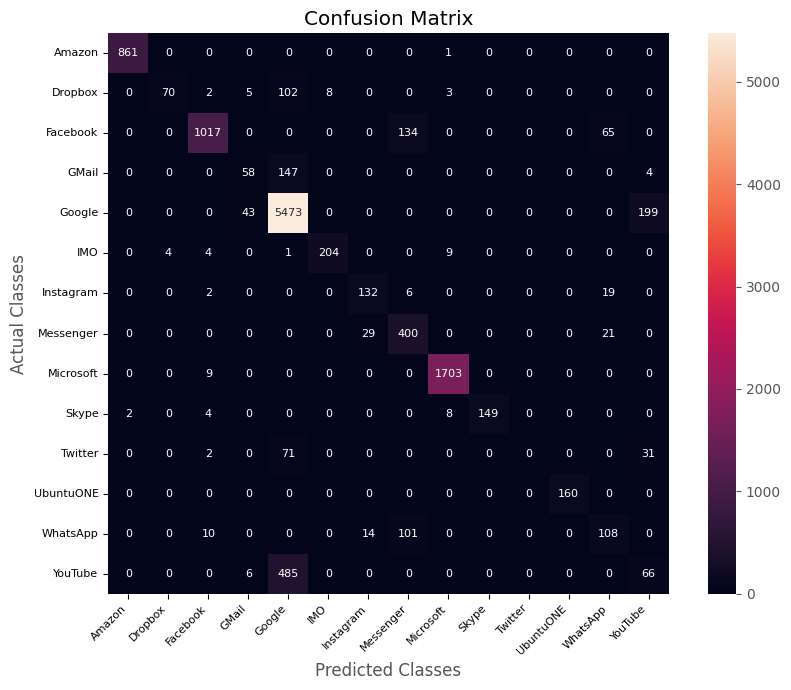

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

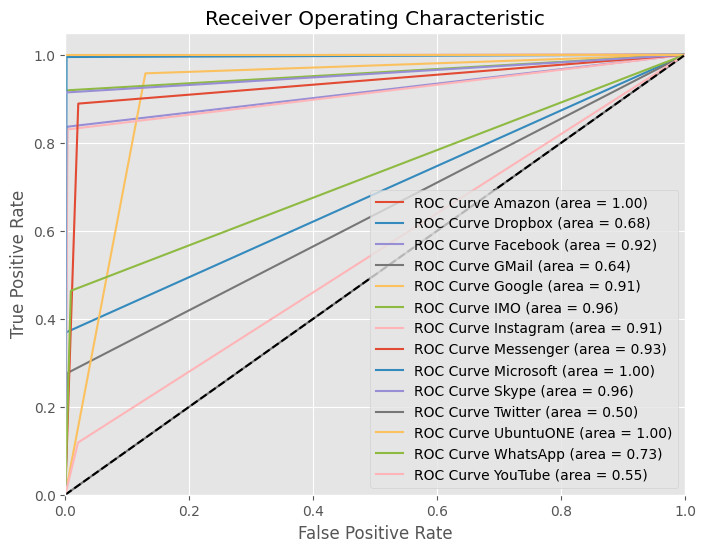

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 2.3. Dataset Oversampling Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_over2.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795700 entries, 397849 to 711450
Data columns (total 40 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     795700 non-null  int64  
 1   src_port           795700 non-null  int64  
 2   dst_port           795700 non-null  int64  
 3   proto              795700 non-null  int64  
 4   pktTotalCount      795700 non-null  int64  
 5   octetTotalCount    795700 non-null  int64  
 6   min_ps             795700 non-null  int64  
 7   max_ps             795700 non-null  int64  
 8   avg_ps             795700 non-null  float64
 9   std_dev_ps         795700 non-null  float64
 10  flowStart          795700 non-null  float64
 11  flowEnd            795700 non-null  float64
 12  flowDuration       795700 non-null  float64
 13  min_piat           795700 non-null  float64
 14  max_piat           795700 non-null  float64
 15  avg_piat           795700 non-null  float64
 1

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Google       341434
Microsoft    103674
Facebook      72482
Amazon        52733
YouTube       33377
Messenger     32000
IMO           26000
WhatsApp      26000
Dropbox       22000
GMail         22000
Instagram     18000
Skype         18000
UbuntuONE     16000
Twitter       12000
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_target  = data["web_service"]

In [ ]:
# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_target  = data_val["web_service"]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_feature[list_cols])
train_feature[list_cols] = scaler.transform(train_feature[list_cols])
train_scaled = pd.concat([train_feature[list_cols], train_feature[categorical], train_target], axis=1)

val_feature[list_cols] = scaler.transform(val_feature[list_cols])
val_scaled = pd.concat([val_feature[list_cols], val_feature[categorical], val_target], axis=1)

In [ ]:
# Create the sequences and labels using the `create_sequences` function
train_segment, train_label = create_sequences(train_scaled, 'web_service')

100%|██████████| 39778/39778 [00:34<00:00, 1143.13it/s]


In [ ]:
# apply sequence segmentation on dataset
val_segment, val_label = create_sequences(val_scaled,'web_service')

# check dimension
print(val_segment.shape, val_label.shape)

100%|██████████| 11952/11952 [00:10<00:00, 1107.49it/s]


(11952, 150, 37) (11952,)


In [ ]:
import numpy as np

unique, counts = np.unique(train_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '2633']
 ['Dropbox' '1100']
 ['Facebook' '3625']
 ['GMail' '1100']
 ['Google' '17071']
 ['IMO' '1300']
 ['Instagram' '900']
 ['Messenger' '1600']
 ['Microsoft' '5184']
 ['Skype' '900']
 ['Twitter' '600']
 ['UbuntuONE' '800']
 ['WhatsApp' '1300']
 ['YouTube' '1665']]


In [ ]:
import numpy as np

unique, counts = np.unique(val_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '874']
 ['Dropbox' '187']
 ['Facebook' '1203']
 ['GMail' '207']
 ['Google' '5705']
 ['IMO' '231']
 ['Instagram' '153']
 ['Messenger' '451']
 ['Microsoft' '1724']
 ['Skype' '158']
 ['Twitter' '109']
 ['UbuntuONE' '155']
 ['WhatsApp' '236']
 ['YouTube' '559']]


In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target" variable
encoder = LabelEncoder()
encoder.fit(train_target.values)

# apply on train-test segmented label
train_label_encode = encoder.transform(train_label)
train_categorical  = to_categorical(train_label_encode)
val_label_encode  = encoder.transform(val_label)
val_categorical  = to_categorical(val_label_encode)

# check dimension
print(train_categorical.shape, val_categorical.shape)

(39778, 14) (11952, 14)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(LSTM(512, input_shape = (train_segment.shape[1], train_segment.shape[2]), return_sequences=True))
  model.add(LSTM(256))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(14, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=list_metrics)
  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 512)          1126400   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 1,983,246
Trainable params: 1,983,246
Non-trainable params: 0
_________________________________________________________________


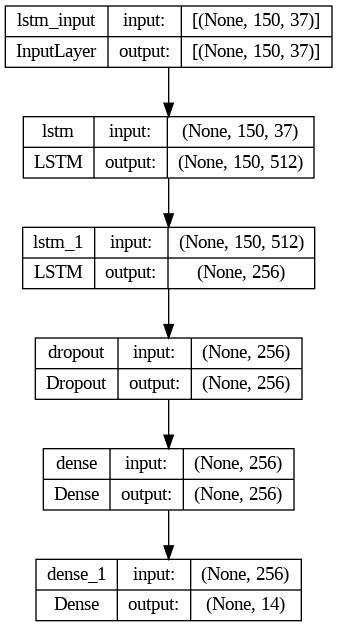

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/lstm_over.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    train_segment, train_categorical,
    validation_data = (val_segment, val_categorical),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
621/622 [============================>.] - ETA: 0s - loss: 1.1483 - accuracy: 0.6315 - precision: 0.7425 - recall: 0.5145 - F1Score: 0.5995
Epoch 1: val_accuracy improved from -inf to 0.85827, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/lstm_over.h5
622/622 [==============================] - 47s 59ms/step - loss: 1.1484 - accuracy: 0.6313 - precision: 0.7423 - recall: 0.5144 - F1Score: 0.5993 - val_loss: 0.6118 - val_accuracy: 0.8583 - val_precision: 0.8993 - val_recall: 0.8047 - val_F1Score: 0.8219
Epoch 2/50
622/622 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.7357 - precision: 0.7918 - recall: 0.6758 - F1Score: 0.7285
Epoch 2: val_accuracy did not improve from 0.85827
622/622 [==============================] - 33s 53ms/step - loss: 0.7959 - accuracy: 0.7357 - precision: 0.7918 - recall: 0.6758 - F1Score: 0.7285 - val_loss: 1.1031 - val_accuracy: 0.4689 - val_precision: 0.4745 - val_recall: 0.3704 - val_F1Score: 0.3936
Epoch 3/50


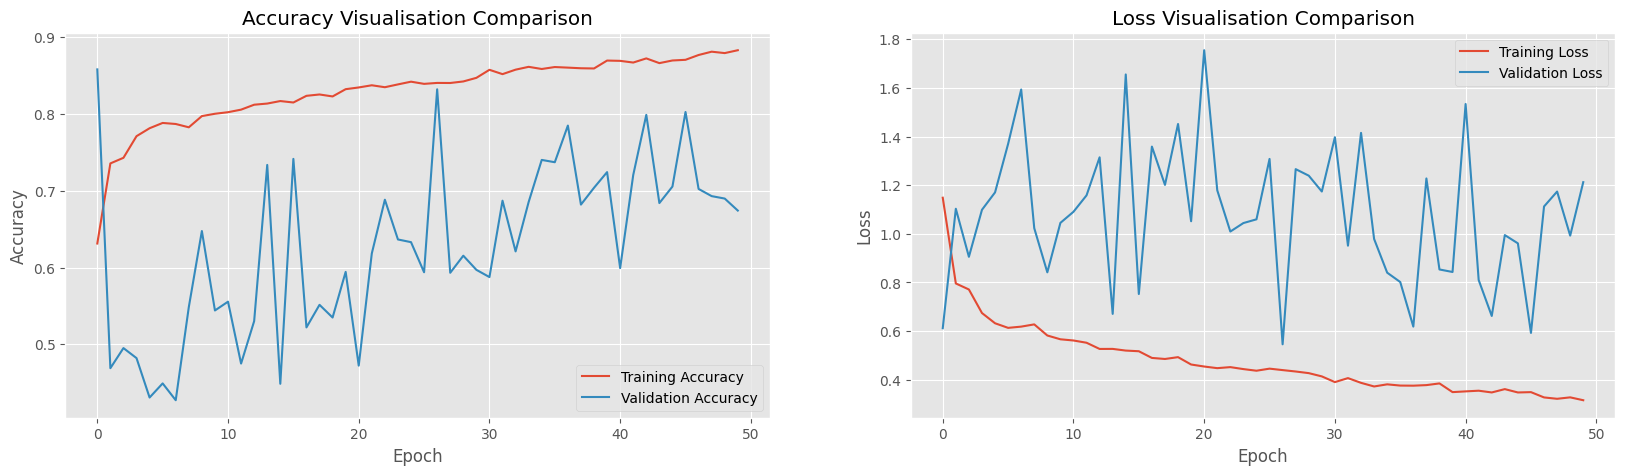

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")


plt.show()

In [ ]:
# get true & predict label
y_preds = model.predict(val_segment).argmax(axis = 1)
y_true  = val_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 6s 13ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       874
     Dropbox       0.92      0.57      0.71       187
    Facebook       0.89      0.98      0.93      1203
       GMail       0.06      0.97      0.12       207
      Google       0.95      0.52      0.67      5705
         IMO       1.00      0.98      0.99       231
   Instagram       0.39      0.49      0.43       153
   Messenger       0.83      0.74      0.78       451
   Microsoft       1.00      1.00      1.00      1724
       Skype       1.00      0.73      0.85       158
     Twitter       0.06      0.07      0.06       109
   UbuntuONE       1.00      0.53      0.69       155
    WhatsApp       0.48      0.37      0.42       236
     YouTube       0.42      0.18      0.25       559

    accuracy                           0.67     11952
   macro avg       0.71      0.65      0.64     11952
weighted avg       0.89 

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/lstm_over.h5")

In [ ]:
# check dimension
data_test.shape

(239175, 43)

In [ ]:
# define feature and target
test_feature = data_test.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
test_target  = data_test["web_service"]

# scaler = MinMaxScaler()
test_feature[list_cols] = scaler.transform(test_feature[list_cols])
test_scaled = pd.concat([test_feature[list_cols], test_feature[categorical], test_target], axis=1)

In [ ]:

# preprocess feature using sequence method
test_segment, test_label = create_sequences(test_scaled, 'web_service')

# encode label
target_encode = encoder.transform(test_label)
test_categorical = to_categorical(target_encode)

100%|██████████| 11952/11952 [00:10<00:00, 1108.54it/s]


In [ ]:
import numpy as np

unique, counts = np.unique(test_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '862']
 ['Dropbox' '190']
 ['Facebook' '1216']
 ['GMail' '209']
 ['Google' '5715']
 ['IMO' '222']
 ['Instagram' '159']
 ['Messenger' '450']
 ['Microsoft' '1712']
 ['Skype' '163']
 ['Twitter' '104']
 ['UbuntuONE' '160']
 ['WhatsApp' '233']
 ['YouTube' '557']]


In [ ]:
# check dimension
test_segment.shape, test_categorical.shape

((11952, 150, 37), (11952, 14))

In [ ]:
# get true & predict label from validation dataset
y_preds = model.predict(test_segment).argmax(axis = 1)
y_true  = test_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

      Amazon       1.00      0.92      0.96       862
     Dropbox       0.00      0.00      0.00       190
    Facebook       0.77      1.00      0.87      1216
       GMail       0.00      0.00      0.00       209
      Google       0.84      1.00      0.91      5715
         IMO       0.97      0.89      0.93       222
   Instagram       0.80      0.13      0.22       159
   Messenger       0.87      0.72      0.79       450
   Microsoft       0.99      0.99      0.99      1712
       Skype       0.74      0.92      0.82       163
     Twitter       0.00      0.00      0.00       104
   UbuntuONE       1.00      0.98      0.99       160
    WhatsApp       0.26      0.13      0.18       233
     YouTube       0.00      0.00      0.00       557

    accuracy                           0.86     11952
   macro avg       0.59      0.55      0.55     11952
weighted avg       0.79 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


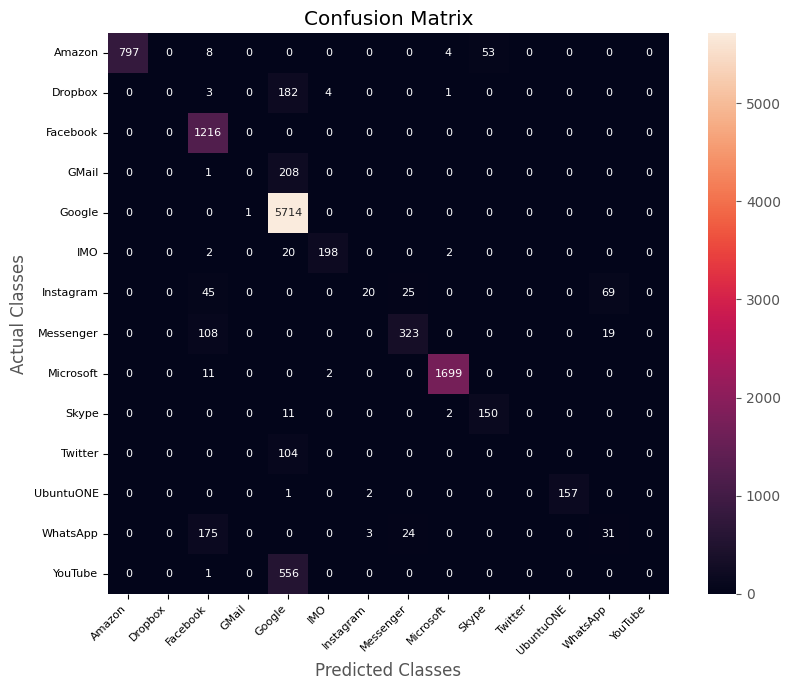

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

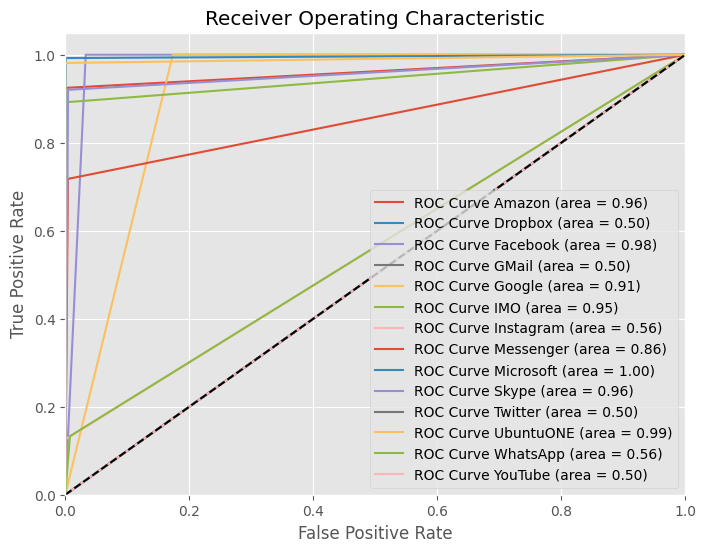

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 3. Bi-LSTM

In [ ]:
# load libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import (
    Dense, BatchNormalization, LSTM, Dropout, Flatten,
    MaxPooling1D, SpatialDropout1D, GRU, Bidirectional
    )

In [ ]:
# setup backend of  visualisation
plt.style.use("ggplot")

In [ ]:
# define f1-score metrics
def F1Score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# define list_metrics used for iterate learning
list_metrics = ["accuracy", Precision(), Recall(), F1Score]

# define global variable for training model
EPOCHS = 50
BATCH_SIZE = 64
TIME_PERIODS = 150
STEP_DISTANCE = 20

In [ ]:
def create_sequences(df, target_var, seq_length=TIME_PERIODS, step=STEP_DISTANCE):

    def get_sequence_label(seq_df):
        return seq_df[target_var].mode()[0]

    sequences = []
    labels = []

    for i in tqdm(range(0, len(df) - seq_length + 1, step)):
        seq_df = df.iloc[i:i+seq_length]

        if len(seq_df) == seq_length:
            sequences.append(seq_df.drop(columns=[target_var]).values)
            labels.append(get_sequence_label(seq_df))

    sequences = np.array(sequences)
    labels = np.array(labels)

    return sequences, labels


In [ ]:
list_cols = [ "pktTotalCount", "octetTotalCount", "min_ps", "max_ps", "avg_ps",
    "std_dev_ps", "flowStart", "flowEnd", "flowDuration",
    "min_piat", "max_piat", "avg_piat", "std_dev_piat", "f_pktTotalCount",
"f_octetTotalCount", "f_max_ps", "f_avg_ps", "f_std_dev_ps", "f_min_piat",
"f_max_piat", "f_avg_piat", "f_std_dev_piat", "b_pktTotalCount",
 "b_octetTotalCount", "b_max_ps", "b_avg_ps", "b_std_dev_ps", "b_min_piat",
"b_max_piat", "b_avg_piat", "b_std_dev_piat",]

categorical = ["src_ip_numeric", "dst_ip_numeric", "src_port", "dst_port", "proto", "flowEndReason" ]

# define clasas "web_service" based Pre-Preprocessing notebook
list_targets = [
    "Amazon", "Dropbox", "Facebook", "GMail", "Google", "IMO",
    "Instagram", "Messenger", "Microsoft",
    "Skype","Twitter", "UbuntuONE", "WhatsApp",  "YouTube"
]


In [ ]:
# load test dataset
data_test = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_test.csv")

In [ ]:
data_val = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_val.csv")

## 3.1. Dataset Normal Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_norm.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717525 entries, 222409 to 197752
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     717525 non-null  int64  
 1   src_port           717525 non-null  int64  
 2   dst_port           717525 non-null  int64  
 3   proto              717525 non-null  int64  
 4   pktTotalCount      717525 non-null  int64  
 5   octetTotalCount    717525 non-null  int64  
 6   min_ps             717525 non-null  int64  
 7   max_ps             717525 non-null  int64  
 8   avg_ps             717525 non-null  float64
 9   std_dev_ps         717525 non-null  float64
 10  flowStart          717525 non-null  float64
 11  flowEnd            717525 non-null  float64
 12  flowDuration       717525 non-null  float64
 13  min_piat           717525 non-null  float64
 14  max_piat           717525 non-null  float64
 15  avg_piat           717525 non-null  float64
 1

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Google       341434
Microsoft    103674
Facebook      72482
Amazon        52733
YouTube       33377
Messenger     27146
WhatsApp      14431
IMO           13783
GMail         12413
Dropbox       11680
Skype          9509
Instagram      9423
UbuntuONE      9067
Twitter        6373
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_target  = data["web_service"]

# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_target  = data_val["web_service"]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_feature[list_cols])
train_feature[list_cols] = scaler.transform(train_feature[list_cols])
train_scaled = pd.concat([train_feature[list_cols], train_feature[categorical], train_target], axis=1)

val_feature[list_cols] = scaler.transform(val_feature[list_cols])
val_scaled = pd.concat([val_feature[list_cols], val_feature[categorical], val_target], axis=1)

In [ ]:
# apply sequence segmentation on dataset
train_segment, train_label = create_sequences(train_scaled, 'web_service')

# check dimension
print(train_segment.shape, train_label.shape)

100%|██████████| 35869/35869 [00:31<00:00, 1145.69it/s]


(35869, 150, 37) (35869,)


In [ ]:
# apply sequence segmentation on dataset
val_segment, val_label = create_sequences(val_scaled, 'web_service')

# check dimension
print(val_segment.shape, val_label.shape)

100%|██████████| 11952/11952 [00:10<00:00, 1107.92it/s]


(11952, 150, 37) (11952,)


In [ ]:
import numpy as np

unique, counts = np.unique(train_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '2633']
 ['Dropbox' '584']
 ['Facebook' '3625']
 ['GMail' '620']
 ['Google' '17072']
 ['IMO' '689']
 ['Instagram' '471']
 ['Messenger' '1357']
 ['Microsoft' '5184']
 ['Skype' '476']
 ['Twitter' '318']
 ['UbuntuONE' '454']
 ['WhatsApp' '721']
 ['YouTube' '1665']]


In [ ]:
import numpy as np

unique, counts = np.unique(val_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '874']
 ['Dropbox' '187']
 ['Facebook' '1203']
 ['GMail' '207']
 ['Google' '5705']
 ['IMO' '231']
 ['Instagram' '153']
 ['Messenger' '451']
 ['Microsoft' '1724']
 ['Skype' '158']
 ['Twitter' '109']
 ['UbuntuONE' '155']
 ['WhatsApp' '236']
 ['YouTube' '559']]


In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target" variable
encoder = LabelEncoder()
encoder.fit(train_target.values)

# apply on train-test segmented label
train_label_encode = encoder.transform(train_label)
train_categorical  = to_categorical(train_label_encode)
val_label_encode  = encoder.transform(val_label)
val_categorical  = to_categorical(val_label_encode)

# check dimension
print(train_categorical.shape, val_categorical.shape)

(35869, 14) (11952, 14)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (train_segment.shape[1], train_segment.shape[2])))
  model.add(Bidirectional(LSTM(256)))
  model.add(Dropout(0.2))

  model.add(Dense(256, activation = "relu"))

  model.add(Dense(14, activation = "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = list_metrics)

  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 150, 1024)        2252800   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              2623488   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 14)                3598      
                                                                 
Total params: 5,011,214
Trainable params: 5,011,214
No

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_norm2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    train_segment, train_categorical,
    validation_data = (val_segment, val_categorical),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
561/561 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8635 - precision_1: 0.8974 - recall_1: 0.8351 - F1Score: 0.8602
Epoch 1: val_accuracy improved from -inf to 0.91022, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/bilstm_norm2.h5
561/561 [==============================] - 81s 131ms/step - loss: 0.4732 - accuracy: 0.8635 - precision_1: 0.8974 - recall_1: 0.8351 - F1Score: 0.8602 - val_loss: 0.2879 - val_accuracy: 0.9102 - val_precision_1: 0.9253 - val_recall_1: 0.8991 - val_F1Score: 0.9079
Epoch 2/50
561/561 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.9142 - precision_1: 0.9245 - recall_1: 0.9038 - F1Score: 0.9141
Epoch 2: val_accuracy improved from 0.91022 to 0.92026, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/bilstm_norm2.h5
561/561 [==============================] - 72s 129ms/step - loss: 0.2860 - accuracy: 0.9142 - precision_1: 0.9245 - recall_1: 0.9038 - F1Score: 0.9141 - val_loss: 0.

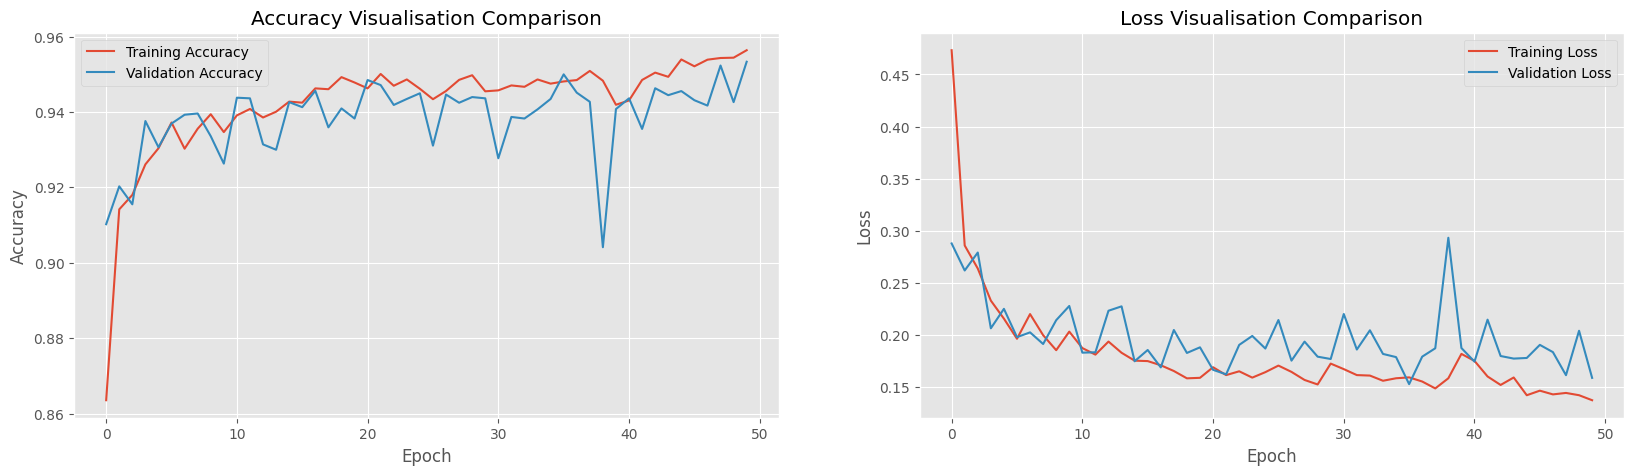

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_norm2.h5")

In [ ]:
# get true & predict label
y_preds = model.predict(val_segment).argmax(axis = 1)
y_true  = val_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 12s 27ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       874
     Dropbox       0.99      0.86      0.92       187
    Facebook       0.95      0.99      0.97      1203
       GMail       0.78      0.38      0.51       207
      Google       0.95      0.99      0.97      5705
         IMO       0.92      0.99      0.95       231
   Instagram       0.82      0.86      0.84       153
   Messenger       0.93      0.87      0.90       451
   Microsoft       1.00      1.00      1.00      1724
       Skype       0.99      0.97      0.98       158
     Twitter       0.78      0.06      0.12       109
   UbuntuONE       1.00      0.99      0.99       155
    WhatsApp       0.77      0.69      0.73       236
     YouTube       0.94      0.86      0.90       559

    accuracy                           0.95     11952
   macro avg       0.92      0.82      0.84     11952
weighted avg       0.95

In [ ]:
# define feature and target
test_feature = data_test.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
test_target  = data_test["web_service"]

# scaler = MinMaxScaler()
test_feature[list_cols] = scaler.transform(test_feature[list_cols])
test_scaled = pd.concat([test_feature[list_cols], test_feature[categorical], test_target], axis=1)

In [ ]:

# preprocess feature using sequence method
test_segment, test_label = create_sequences(test_scaled,'web_service')

100%|██████████| 11952/11952 [00:10<00:00, 1123.45it/s]


In [ ]:
import numpy as np

unique, counts = np.unique(test_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '862']
 ['Dropbox' '190']
 ['Facebook' '1216']
 ['GMail' '209']
 ['Google' '5715']
 ['IMO' '222']
 ['Instagram' '159']
 ['Messenger' '450']
 ['Microsoft' '1712']
 ['Skype' '163']
 ['Twitter' '104']
 ['UbuntuONE' '160']
 ['WhatsApp' '233']
 ['YouTube' '557']]


In [ ]:
encoder = LabelEncoder()

# encode label
target_encode = encoder.fit_transform(test_label)
test_categorical = to_categorical(target_encode)

In [ ]:
# check dimension
test_segment.shape, test_categorical.shape

((11952, 150, 37), (11952, 14))

In [ ]:
# get true & predict label from validation dataset
y_preds = model.predict(test_segment).argmax(axis = 1)
y_true  = test_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 10s 27ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       862
     Dropbox       0.99      0.76      0.86       190
    Facebook       0.95      1.00      0.97      1216
       GMail       0.71      0.31      0.43       209
      Google       0.95      0.99      0.97      5715
         IMO       0.84      0.98      0.90       222
   Instagram       0.84      0.86      0.85       159
   Messenger       0.96      0.84      0.90       450
   Microsoft       1.00      1.00      1.00      1712
       Skype       1.00      0.97      0.98       163
     Twitter       0.95      0.19      0.32       104
   UbuntuONE       0.99      1.00      1.00       160
    WhatsApp       0.72      0.72      0.72       233
     YouTube       0.93      0.92      0.92       557

    accuracy                           0.95     11952
   macro avg       0.92      0.82      0.84     11952
weighted avg       0.95

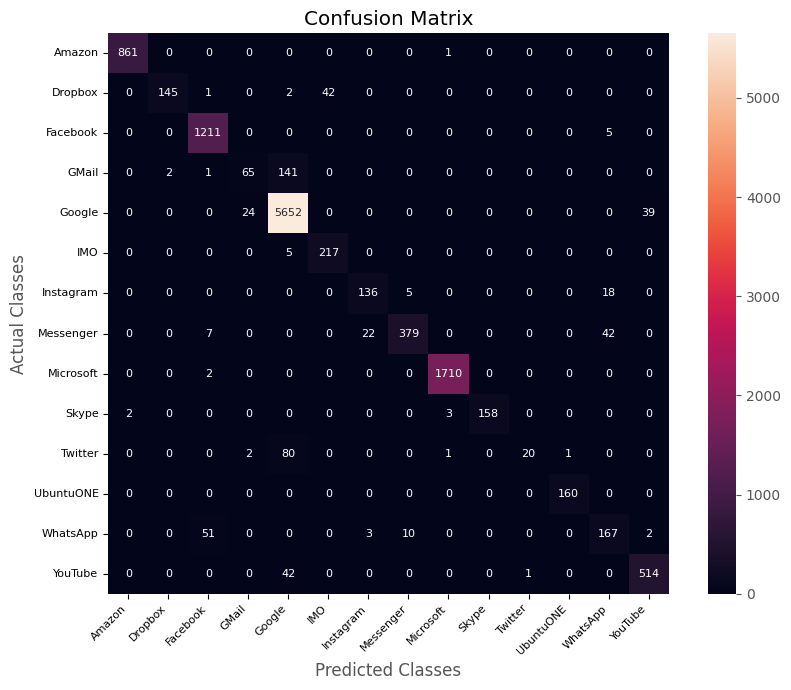

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()


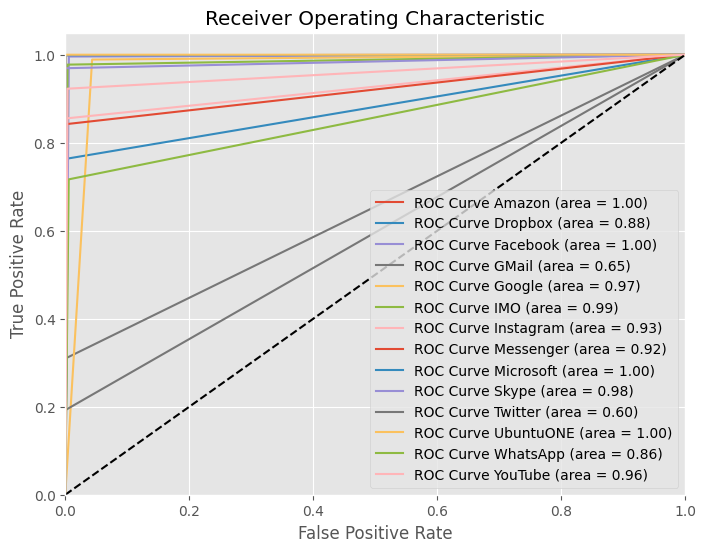

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 3.2. Dataset Undersampling Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_under2.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263825 entries, 51145 to 102290
Data columns (total 40 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     263825 non-null  int64  
 1   src_port           263825 non-null  int64  
 2   dst_port           263825 non-null  int64  
 3   proto              263825 non-null  int64  
 4   pktTotalCount      263825 non-null  int64  
 5   octetTotalCount    263825 non-null  int64  
 6   min_ps             263825 non-null  int64  
 7   max_ps             263825 non-null  int64  
 8   avg_ps             263825 non-null  float64
 9   std_dev_ps         263825 non-null  float64
 10  flowStart          263825 non-null  float64
 11  flowEnd            263825 non-null  float64
 12  flowDuration       263825 non-null  float64
 13  min_piat           263825 non-null  float64
 14  max_piat           263825 non-null  float64
 15  avg_piat           263825 non-null  float64
 16

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Amazon       30000
Facebook     30000
Google       30000
Microsoft    30000
YouTube      30000
Messenger    27146
WhatsApp     14431
IMO          13783
GMail        12413
Dropbox      11680
Skype         9509
Instagram     9423
UbuntuONE     9067
Twitter       6373
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_target  = data["web_service"]

# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_target  = data_val["web_service"]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_feature[list_cols])
train_feature[list_cols] = scaler.transform(train_feature[list_cols])
train_scaled = pd.concat([train_feature[list_cols], train_feature[categorical], train_target], axis=1)

val_feature[list_cols] = scaler.transform(val_feature[list_cols])
val_scaled = pd.concat([val_feature[list_cols], val_feature[categorical],val_target], axis=1)

In [ ]:
# apply sequence segmentation on dataset
train_segment, train_label = create_sequences(train_scaled, 'web_service')

# check dimension
print(train_segment.shape, train_label.shape)

100%|██████████| 13184/13184 [00:13<00:00, 979.93it/s]


(13184, 150, 37) (13184,)


In [ ]:
# apply sequence segmentation on dataset
val_segment, val_label = create_sequences(val_scaled, 'web_service')

# check dimension
print(val_segment.shape, val_label.shape)

100%|██████████| 11952/11952 [00:11<00:00, 1075.01it/s]


(11952, 150, 37) (11952,)


In [ ]:
import numpy as np

unique, counts = np.unique(train_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '1497']
 ['Dropbox' '584']
 ['Facebook' '1500']
 ['GMail' '620']
 ['Google' '1500']
 ['IMO' '690']
 ['Instagram' '471']
 ['Messenger' '1357']
 ['Microsoft' '1500']
 ['Skype' '475']
 ['Twitter' '319']
 ['UbuntuONE' '453']
 ['WhatsApp' '722']
 ['YouTube' '1496']]


In [ ]:
import numpy as np

unique, counts = np.unique(val_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '874']
 ['Dropbox' '187']
 ['Facebook' '1203']
 ['GMail' '207']
 ['Google' '5705']
 ['IMO' '231']
 ['Instagram' '153']
 ['Messenger' '451']
 ['Microsoft' '1724']
 ['Skype' '158']
 ['Twitter' '109']
 ['UbuntuONE' '155']
 ['WhatsApp' '236']
 ['YouTube' '559']]


In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target" variable
encoder = LabelEncoder()
encoder.fit(train_target.values)

# apply on train-test segmented label
train_label_encode = encoder.transform(train_label)
train_categorical  = to_categorical(train_label_encode)
val_label_encode  = encoder.transform(val_label)
val_categorical  = to_categorical(val_label_encode)

# check dimension
print(train_categorical.shape, val_categorical.shape)

(13184, 14) (11952, 14)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (train_segment.shape[1], train_segment.shape[2])))
  model.add(Bidirectional(LSTM(256)))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation = "relu"))

  model.add(Dense(14, activation = "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = list_metrics)

  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 150, 1024)        2252800   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              2623488   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 5,011,214
Trainable params: 5,011,214
No

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_under.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    train_segment, train_categorical,
    validation_data = (val_segment, val_categorical),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
206/206 [==============================] - ETA: 0s - loss: 1.3878 - accuracy: 0.4952 - precision_1: 0.8781 - recall_1: 0.5983 - F1Score: 0.3856
Epoch 1: val_accuracy improved from -inf to 0.86253, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/bilstm_under.h5
206/206 [==============================] - 40s 165ms/step - loss: 1.3878 - accuracy: 0.4952 - precision_1: 0.8781 - recall_1: 0.5983 - F1Score: 0.3856 - val_loss: 0.7653 - val_accuracy: 0.8625 - val_precision_1: 0.9609 - val_recall_1: 0.3806 - val_F1Score: 0.4133
Epoch 2/50
206/206 [==============================] - ETA: 0s - loss: 1.1508 - accuracy: 0.5726 - precision_1: 0.7173 - recall_1: 0.3895 - F1Score: 0.5023
Epoch 2: val_accuracy improved from 0.86253 to 0.86354, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/bilstm_under.h5
206/206 [==============================] - 34s 165ms/step - loss: 1.1508 - accuracy: 0.5726 - precision_1: 0.7173 - recall_1: 0.3895 - F1Score: 0.5023 - val_loss: 0.

In [ ]:
# save model
model.save_weights("/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_under_weights.h5")

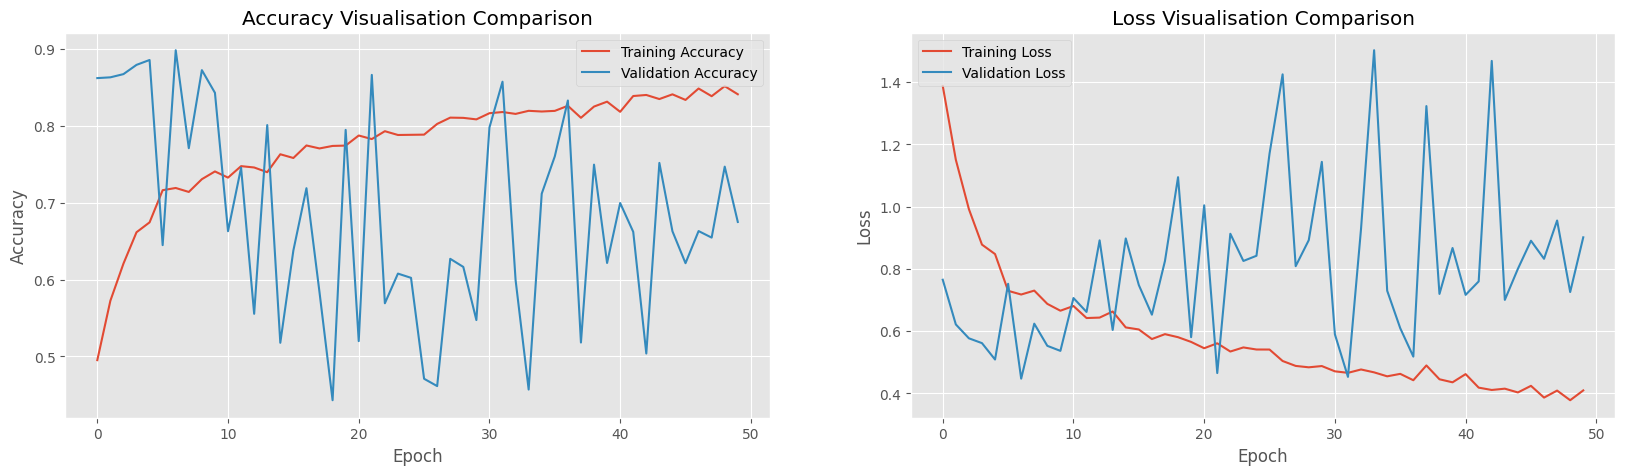

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")


plt.show()

In [ ]:
# get true & predict label
y_preds = model.predict(val_segment).argmax(axis = 1)
y_true  = val_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 12s 27ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       874
     Dropbox       0.86      0.86      0.86       187
    Facebook       0.97      0.89      0.93      1203
       GMail       0.06      0.96      0.11       207
      Google       0.97      0.52      0.67      5705
         IMO       0.98      0.95      0.96       231
   Instagram       0.48      0.83      0.61       153
   Messenger       0.84      0.41      0.55       451
   Microsoft       1.00      1.00      1.00      1724
       Skype       1.00      0.97      0.99       158
     Twitter       0.41      0.14      0.21       109
   UbuntuONE       0.99      0.99      0.99       155
    WhatsApp       0.46      0.91      0.61       236
     YouTube       0.60      0.06      0.11       559

    accuracy                           0.68     11952
   macro avg       0.76      0.75      0.69     11952
weighted avg       0.92

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_under.h5")

In [ ]:
# define feature and target
test_feature = data_test.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
test_target  = data_test["web_service"]

# scaler = MinMaxScaler()
test_feature[list_cols] = scaler.transform(test_feature[list_cols])
test_scaled = pd.concat([test_feature[list_cols], test_feature[categorical], test_target], axis=1)

In [ ]:
# preprocess feature using sequence method
test_segment, test_label = create_sequences(test_scaled,'web_service')

# encode label
encoder = LabelEncoder()
target_encode = encoder.fit_transform(test_label)
test_categorical = to_categorical(target_encode)

100%|██████████| 11952/11952 [00:10<00:00, 1111.61it/s]


In [ ]:
import numpy as np

unique, counts = np.unique(test_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '862']
 ['Dropbox' '190']
 ['Facebook' '1216']
 ['GMail' '209']
 ['Google' '5715']
 ['IMO' '222']
 ['Instagram' '159']
 ['Messenger' '450']
 ['Microsoft' '1712']
 ['Skype' '163']
 ['Twitter' '104']
 ['UbuntuONE' '160']
 ['WhatsApp' '233']
 ['YouTube' '557']]


In [ ]:
# check dimension
test_segment.shape, test_categorical.shape

((11952, 150, 37), (11952, 14))

In [ ]:
# get true & predict label from validation dataset
y_preds = model.predict(test_segment).argmax(axis = 1)
y_true  = test_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 11s 28ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       862
     Dropbox       0.96      0.67      0.79       190
    Facebook       0.88      1.00      0.93      1216
       GMail       0.38      0.13      0.19       209
      Google       0.87      0.99      0.92      5715
         IMO       0.99      0.93      0.96       222
   Instagram       0.85      0.78      0.81       159
   Messenger       0.92      0.78      0.84       450
   Microsoft       0.99      1.00      0.99      1712
       Skype       0.99      0.99      0.99       163
     Twitter       0.00      0.00      0.00       104
   UbuntuONE       0.99      0.99      0.99       160
    WhatsApp       0.45      0.31      0.37       233
     YouTube       0.00      0.00      0.00       557

    accuracy                           0.89     11952
   macro avg       0.73      0.68      0.70     11952
weighted avg       0.84

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


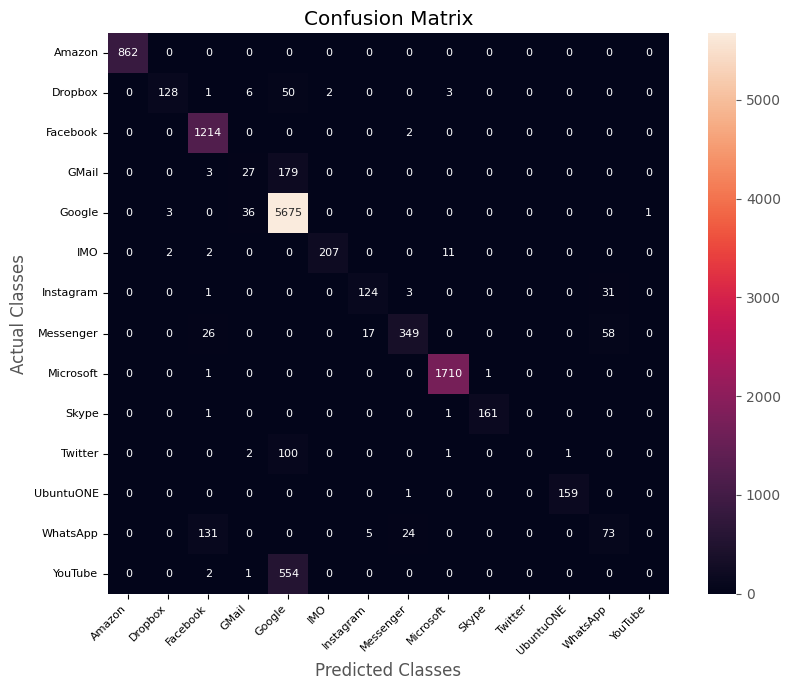

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

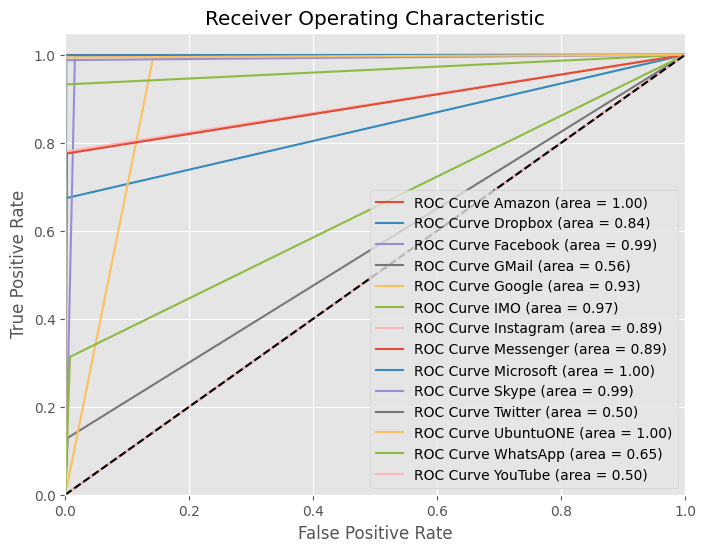

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 3.2. Dataset Oversampling Distribution

In [ ]:
# read dataset
data = pd.read_csv("/content/drive/MyDrive/07/Skripsi/Progress7/data_train_over2.csv")

In [ ]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795700 entries, 397849 to 711450
Data columns (total 40 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip_numeric     795700 non-null  int64  
 1   src_port           795700 non-null  int64  
 2   dst_port           795700 non-null  int64  
 3   proto              795700 non-null  int64  
 4   pktTotalCount      795700 non-null  int64  
 5   octetTotalCount    795700 non-null  int64  
 6   min_ps             795700 non-null  int64  
 7   max_ps             795700 non-null  int64  
 8   avg_ps             795700 non-null  float64
 9   std_dev_ps         795700 non-null  float64
 10  flowStart          795700 non-null  float64
 11  flowEnd            795700 non-null  float64
 12  flowDuration       795700 non-null  float64
 13  min_piat           795700 non-null  float64
 14  max_piat           795700 non-null  float64
 15  avg_piat           795700 non-null  float64
 1

In [ ]:
# overview normal "web_service" distribution
data["web_service"].value_counts()

Google       341434
Microsoft    103674
Facebook      72482
Amazon        52733
YouTube       33377
Messenger     32000
IMO           26000
WhatsApp      26000
Dropbox       22000
GMail         22000
Instagram     18000
Skype         18000
UbuntuONE     16000
Twitter       12000
Name: web_service, dtype: int64

In [ ]:
# define feature and target
train_feature = data.drop(['web_service'], axis=1)
train_target  = data["web_service"]

# define feature and target
val_feature = data_val.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
val_target  = data_val["web_service"]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_feature[list_cols])
train_feature[list_cols] = scaler.transform(train_feature[list_cols])
train_scaled = pd.concat([train_feature[list_cols], train_feature[categorical], train_target], axis=1)

val_feature[list_cols] = scaler.transform(val_feature[list_cols])
val_scaled = pd.concat([val_feature[list_cols], val_feature[categorical], val_target], axis=1)

In [ ]:
# apply sequence segmentation on dataset
train_segment, train_label = create_sequences(train_scaled, 'web_service')

# check dimension
print(train_segment.shape, train_label.shape)

100%|██████████| 39778/39778 [00:49<00:00, 807.60it/s] 


(39778, 150, 37) (39778,)


In [ ]:
# apply sequence segmentation on dataset
val_segment, val_label = create_sequences(val_scaled, 'web_service')

# check dimension
print(val_segment.shape, val_label.shape)

100%|██████████| 11952/11952 [00:10<00:00, 1187.91it/s]


(11952, 150, 37) (11952,)


In [ ]:
import numpy as np

unique, counts = np.unique(train_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '2633']
 ['Dropbox' '1100']
 ['Facebook' '3625']
 ['GMail' '1100']
 ['Google' '17071']
 ['IMO' '1300']
 ['Instagram' '900']
 ['Messenger' '1600']
 ['Microsoft' '5184']
 ['Skype' '900']
 ['Twitter' '600']
 ['UbuntuONE' '800']
 ['WhatsApp' '1300']
 ['YouTube' '1665']]


In [ ]:
import numpy as np

unique, counts = np.unique(val_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '874']
 ['Dropbox' '187']
 ['Facebook' '1203']
 ['GMail' '207']
 ['Google' '5705']
 ['IMO' '231']
 ['Instagram' '153']
 ['Messenger' '451']
 ['Microsoft' '1724']
 ['Skype' '158']
 ['Twitter' '109']
 ['UbuntuONE' '155']
 ['WhatsApp' '236']
 ['YouTube' '559']]


In [ ]:
# apply feature engineer (Label Encoder & One Hot Encoder) on "target" variable
encoder = LabelEncoder()
encoder.fit(train_target.values)

# apply on train-test segmented label
train_label_encode = encoder.transform(train_label)
train_categorical  = to_categorical(train_label_encode)
val_label_encode  = encoder.transform(val_label)
val_categorical  = to_categorical(val_label_encode)

# check dimension
print(train_categorical.shape, val_categorical.shape)

(39778, 14) (11952, 14)


In [ ]:
# define model architecture
def build_model():

  model = Sequential()

  model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (train_segment.shape[1], train_segment.shape[2])))
  model.add(Bidirectional(LSTM(256)))
  model.add(Dropout(0.2))

  model.add(Dense(256, activation = "relu"))

  model.add(Dense(14, activation = "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = list_metrics)

  return model

In [ ]:
# inherit model
model = build_model()

# check model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 150, 1024)        2252800   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              2623488   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 14)                3598      
                                                                 
Total params: 5,011,214
Trainable params: 5,011,214
No

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_over.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# training model
history = model.fit(
    train_segment, train_categorical,
    validation_data = (val_segment, val_categorical),
    epochs = 50, batch_size = BATCH_SIZE,
    callbacks = callbacks_list
    )

Epoch 1/50
622/622 [==============================] - ETA: 0s - loss: 1.0521 - accuracy: 0.6649 - precision: 0.7553 - recall: 0.5638 - F1Score: 0.6370
Epoch 1: val_accuracy improved from -inf to 0.84521, saving model to /content/drive/MyDrive/07/Skripsi/Progress7/bilstm_over.h5
622/622 [==============================] - 91s 134ms/step - loss: 1.0521 - accuracy: 0.6649 - precision: 0.7553 - recall: 0.5638 - F1Score: 0.6370 - val_loss: 0.7137 - val_accuracy: 0.8452 - val_precision: 0.9151 - val_recall: 0.5354 - val_F1Score: 0.6243
Epoch 2/50
622/622 [==============================] - ETA: 0s - loss: 0.7840 - accuracy: 0.7391 - precision: 0.7958 - recall: 0.6759 - F1Score: 0.7301
Epoch 2: val_accuracy did not improve from 0.84521
622/622 [==============================] - 78s 125ms/step - loss: 0.7840 - accuracy: 0.7391 - precision: 0.7958 - recall: 0.6759 - F1Score: 0.7301 - val_loss: 1.4179 - val_accuracy: 0.4099 - val_precision: 0.4182 - val_recall: 0.3660 - val_F1Score: 0.3825
Epoch 3

In [ ]:
# save model
model.save_weights("/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_under_weights.h5")

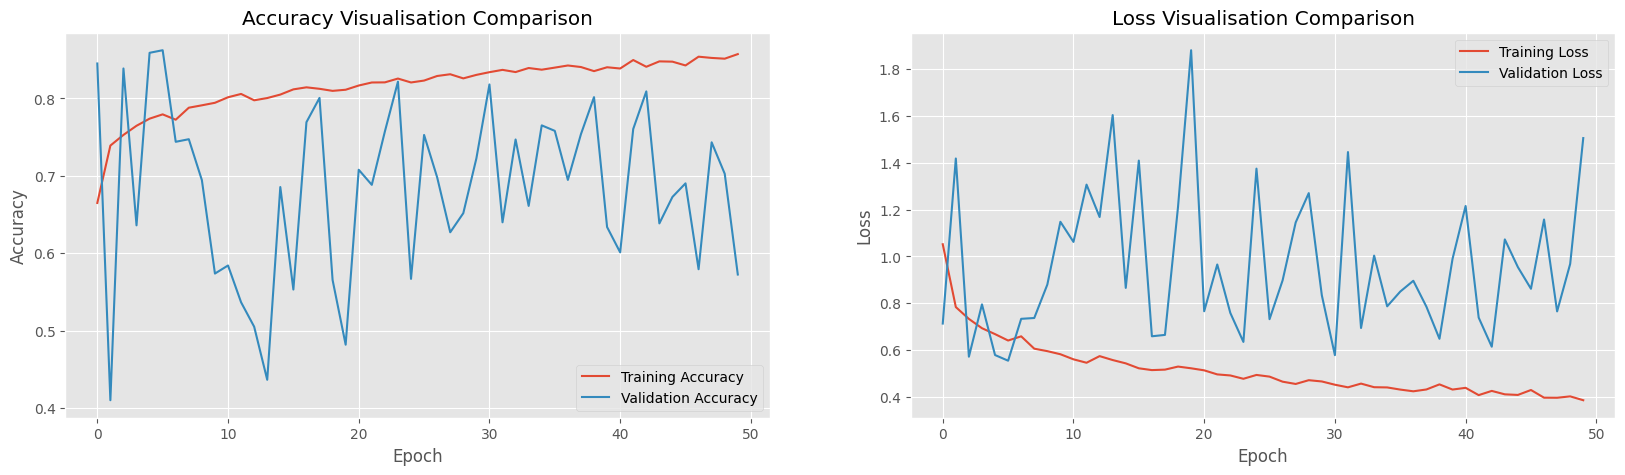

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy Visualisation Comparison")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(history.history['loss'], label = "Training Loss")
ax[1].plot(history.history['val_loss'], label = "Validation Loss")
ax[1].legend()
ax[1].set_title("Loss Visualisation Comparison")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")


plt.show()

In [ ]:
# get true & predict label
y_preds = model.predict(val_segment).argmax(axis = 1)
y_true  = val_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 12s 27ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       874
     Dropbox       1.00      0.45      0.62       187
    Facebook       0.96      0.97      0.96      1203
       GMail       0.04      0.98      0.08       207
      Google       0.93      0.30      0.45      5705
         IMO       1.00      0.97      0.98       231
   Instagram       0.86      0.24      0.37       153
   Messenger       0.72      0.93      0.81       451
   Microsoft       0.97      1.00      0.99      1724
       Skype       1.00      0.98      0.99       158
     Twitter       0.06      0.12      0.08       109
   UbuntuONE       1.00      0.74      0.85       155
    WhatsApp       0.63      0.55      0.59       236
     YouTube       0.57      0.03      0.06       559

    accuracy                           0.57     11952
   macro avg       0.77      0.66      0.63     11952
weighted avg       0.89

In [ ]:
# load trained model
model_trained = model.load_weights("/content/drive/MyDrive/07/Skripsi/Progress7/bilstm_over.h5")

In [ ]:
# check dimension
data_test.shape

In [ ]:
# define feature and target
test_feature = data_test.drop(['web_service', 'application_protocol', 'category', 'flow_key'], axis=1)
test_target  = data_test["web_service"]

# scaler = MinMaxScaler()
test_feature[list_cols] = scaler.transform(test_feature[list_cols])
test_scaled = pd.concat([test_feature[list_cols], test_feature[categorical], test_target], axis=1)

In [ ]:

# preprocess feature using sequence method
test_segment, test_label = create_sequences(test_scaled, 'web_service')

# encode label
target_encode = encoder.transform(test_label)
test_categorical = to_categorical(target_encode)

In [ ]:
import numpy as np

unique, counts = np.unique(test_label, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Amazon' '862']
 ['Dropbox' '190']
 ['Facebook' '1216']
 ['GMail' '209']
 ['Google' '5715']
 ['IMO' '222']
 ['Instagram' '159']
 ['Messenger' '450']
 ['Microsoft' '1712']
 ['Skype' '163']
 ['Twitter' '104']
 ['UbuntuONE' '160']
 ['WhatsApp' '233']
 ['YouTube' '557']]


In [ ]:
# check dimension
test_segment.shape, test_categorical.shape

In [ ]:
# get true & predict label from validation dataset
y_preds = model.predict(test_segment).argmax(axis = 1)
y_true  = test_categorical.argmax(axis = 1)

print(classification_report(y_true, y_preds, target_names = [list_targets[i] for i in np.unique(y_true)]))

374/374 [==============================] - 11s 28ms/step
              precision    recall  f1-score   support

      Amazon       1.00      1.00      1.00       862
     Dropbox       0.00      0.00      0.00       190
    Facebook       0.84      0.99      0.91      1216
       GMail       0.10      0.11      0.10       209
      Google       0.84      0.98      0.90      5715
         IMO       1.00      0.72      0.83       222
   Instagram       0.95      0.23      0.37       159
   Messenger       0.84      0.97      0.90       450
   Microsoft       0.98      1.00      0.99      1712
       Skype       1.00      0.17      0.28       163
     Twitter       0.00      0.00      0.00       104
   UbuntuONE       1.00      0.86      0.93       160
    WhatsApp       0.61      0.54      0.57       233
     YouTube       0.00      0.00      0.00       557

    accuracy                           0.86     11952
   macro avg       0.65      0.54      0.56     11952
weighted avg       0.80

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


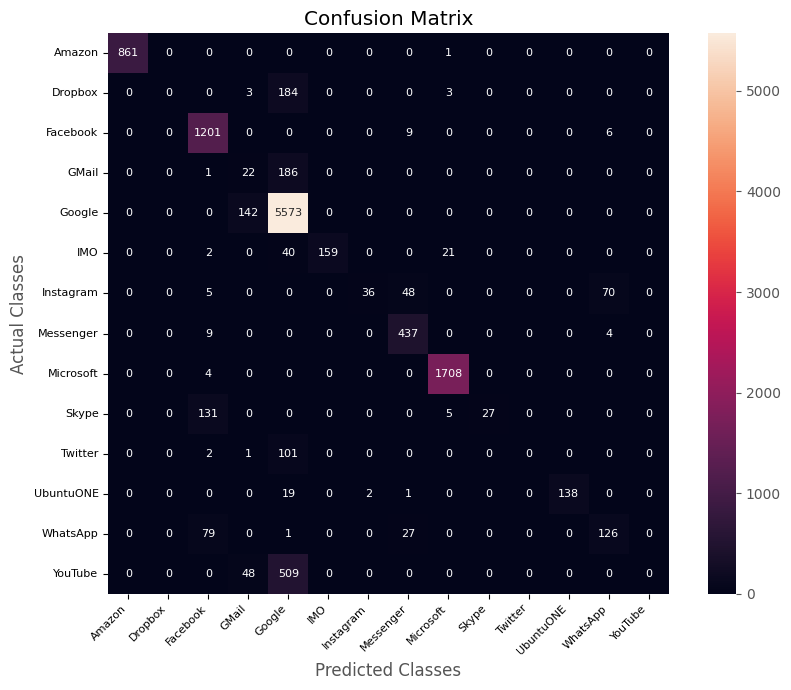

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# compute confusion matrix
conf_mat = confusion_matrix(y_true, y_preds)
# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
# Create the heatmap using seaborn with light theme
sns.heatmap(conf_mat, annot=True, fmt="d",  cbar=True, ax=ax, square = True,  annot_kws={"fontsize": 8})

# Set labels, title, and ticks
ax.set_xlabel("Predicted Classes")
ax.set_ylabel("Actual Classes")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(list_targets, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(list_targets, rotation=0, fontsize=8)


# Set the color of the tick labels to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# adjust plot layout
plt.tight_layout()

# show plot
plt.show()

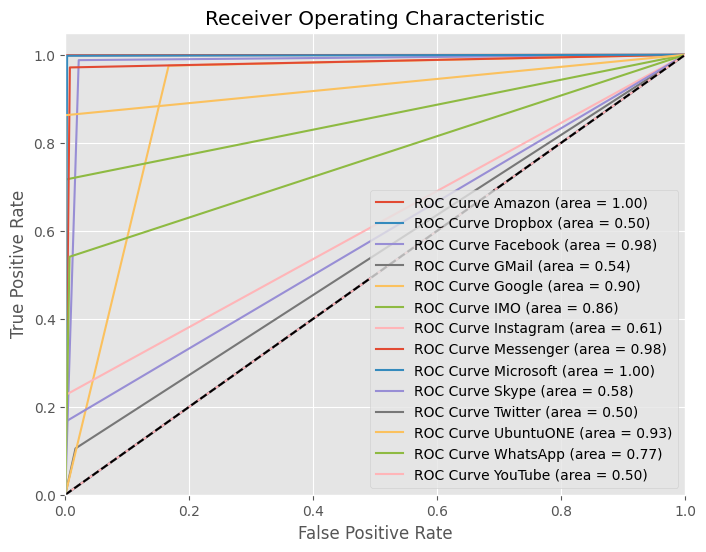

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# compute ROC curve and ROC area for each class
n_classes = len(list_targets)
y_onehot = np.eye(n_classes)[y_true]
y_score = np.eye(n_classes)[y_preds]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC Curve {} (area = {:.2f})'.format(list_targets[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
